In [1]:
import os
from SimpleITK.SimpleITK import And
import numpy as np
import scipy
import SimpleITK as sitk
import matplotlib.pyplot as plt
from skimage.segmentation import join_segmentations
import pandas as pd
from utils import StapleGun4, ImageFlipper


In [2]:
def GetSlices(seg_arr):
    values= []
    for i in range(0,len(seg_arr)):
        val = np.sum(seg_arr[i,:,:])
        #if val >=   :
        if val >= 50750:
            values.append(i)
    return values

def GetSlicesArray(masks):
    slices_array =[]
    for image in masks:
        slices = GetSlices(image)
        slices_array.append((slices))
    return np.asarray(slices_array)

def GetArea(seg_arr, staple_slices, patient):
    values = []
    for i in staple_slices[patient]:
        
        val = np.sum(seg_arr[i,:,:])
        
        val/255
        values.append(val.astype(int))
    return values
def GetAreaArray(masks, masks_ids, staple_id, staple_slices):
    area_array =[]
    masks_ids_l = masks_ids.tolist()
    for id in staple_id:
       
        place_holder = masks_ids_l.index(id)
        
        areas = GetArea(masks[place_holder], staple_slices, place_holder)
        area_array.append(areas)
    return np.asarray(area_array)


def StapleGun(masks_a, masks_b, masks_c, ids_a, ids_b, ids_c):

    """
    slices_array_a = GetSlicesArray(masks_a)
    slices_array_b = GetSlicesArray(masks_b)
    slices_array_c = GetSlicesArray(masks_c)
    """
    #removed CR slices, for when I have all of the data sheets 
    path_a = "/Users/olivia/Documents/PhD/MISTIE/mask_data/CRdata.xlsx"
 
    slices_array_a = NewRemoveCoronaRadiataSlices(masks_a, ids_a, path_a, sheetname='adrian')
    slices_array_b = NewRemoveCoronaRadiataSlices(masks_b, ids_b, path_a, sheetname = 'paul')
    slices_array_c = NewRemoveCoronaRadiataSlices(masks_c, ids_c, path_a, sheetname = 'sacha') 
    

    staple_array = []
    slices_array = []
    id = []
    id_ticker = 0
    

    for i in range (0, 77) :
        id_ticker += 1
        staple_slices_array = []  
        slices_id =[]
        patient_id = ids_a[i]

        for j in slices_array_a[i]:
            if j in slices_array_b[i] and j in slices_array_c[i]:

                masks_a[i][j][masks_a[i][j]==255] = 1
                masks_b[i][j][masks_b[i][j]==255] = 1
                masks_c[i][j][masks_c[i][j]==255] = 1

                mask_a = sitk.GetImageFromArray(masks_a[i][j])
                mask_b = sitk.GetImageFromArray(masks_b[i][j])
                mask_c = sitk.GetImageFromArray(masks_c[i][j])
                

                staple_filter = sitk.STAPLEImageFilter()
                staple_filter.SetForegroundValue(1)
                staple_image = staple_filter.Execute(mask_a,mask_b, mask_c)
                staple_image = staple_image > 0.5                                
                staple_slice_array = sitk.GetArrayFromImage(staple_image)
                iter = staple_filter.GetElapsedIterations()
                print("Patient: ", i, ", Slice: ", j)
                print("iter: ", iter)

                staple_slices_array.append(staple_slice_array)
                slices_id.append(j)
                
        id.append((patient_id))
        staple_array.append(staple_slices_array)
        slices_array.append(slices_id)
        
    return staple_array, id, slices_array

def UnpackNpz(path):
    data = np.load(path, allow_pickle=True)
    masks = data['masks']
    ids = data['ids']
    return masks, ids

def OnesNZeros(mask_array):
    mask_array_copy = mask_array
    slices_array = GetSlicesArray(mask_array_copy)
    for i in range(0, len(mask_array_copy)):
        for slic in slices_array[i]:
            mask_array_copy[i][slic][mask_array_copy[i][slic]==255] = 1
    return mask_array_copy

def HasCoronaRadiata(csv_path, sheetname):
    data_frame = pd.read_excel(csv_path, sheet_name= sheetname, usecols = ['PRIME ID ', 'CR distance to hematoma (mm)'])
    
    CR =data_frame['CR distance to hematoma (mm)'].tolist()
    ids = data_frame['PRIME ID '].tolist()
    ids = [str(x) for x in ids]
    #print("ids: ",ids)
    ind = []
    for i in range(0,len(CR)):
        if CR[i] !=0:
            ind.append(i)

    patients=[]
    for i in ind:
        #print("id data: ", ids[i])
        patient = ids[i][0:4]
        patients.append(patient)
    #print("patients: ", patients)
    return np.asarray(patients, dtype = int)

def RemoveCoronaRadiataSlices(mask_array, mask_ids, csv_path, sheetname):
    removed_slices = []
    mask_ids_dummy = mask_ids.astype(int).tolist()
    patients = HasCoronaRadiata(csv_path, sheetname)
    slices_array = GetSlicesArray(mask_array)
    for id in patients:
        if id in mask_ids_dummy:
            
            ind = mask_ids_dummy.index(id)
            length= len(slices_array[ind])
            if id != 0:
               if len(slices_array[ind]) != 0:
                  slices_array[ind].pop(length-1)
         
    return slices_array

def NewRemoveCoronaRadiataSlices(mask_array, mask_ids, csv_path, sheetname):
    
    removed_slices = []

    slices_array = GetSlicesArray(mask_array)
    mask_ids_dummy = mask_ids.astype(int).tolist()
    data_frame = pd.read_excel(csv_path, sheet_name= sheetname, usecols = ['cr missing','cr upside down' ])
    CR_upsidedown = data_frame['cr upside down'].astype(int).tolist()
    CR_missing = data_frame['cr missing'].astype(int).tolist()
    #print("ids: ",mask_ids_dummy, "upside: ",CR_upsidedown, "missing: ", CR_missing)
    
    for id in mask_ids_dummy:
        
        if id in CR_upsidedown:
            place_holder = mask_ids_dummy.index(id)
            if len(slices_array[place_holder]) != 0:
                slices_array[place_holder].pop(0)
        elif id in CR_missing:
            slices_array = slices_array
        else:
            place_holder = mask_ids_dummy.index(id)
            if len(slices_array[place_holder]) != 0:
                slices_array[place_holder].pop(len(slices_array[place_holder])-1)
    return slices_array



def IdSkip(ids_a,ids_b,ids_c, masks_a, masks_b, masks_c):
    mask_a = masks_a.tolist()
    mask_b = masks_b.tolist()
    mask_c = masks_c.tolist()
    id_a = ids_a.tolist()
    id_b = ids_b.tolist()
    id_c = ids_c.tolist()
    ids_skip =[]
    for id in ids_a:
        if id not in ids_b or id not in ids_c:
            ids_skip.append(id)
    for id in ids_skip:
        if id in ids_a:
            i = id_a.index(id)
            mask_a.pop(i)
            id_a.pop(i)

        if id in ids_b:
            i = id_b.index(id)
            mask_b.pop(i)
            id_b.pop(i)

        if id in ids_c:
            i = id_c.index(id)
            mask_c.pop(i)
            id_c.pop(i)

    return np.asarray(mask_a), np.asarray(id_a), np.asarray(mask_b), np.asarray(id_b), np.asarray(mask_c), np.asarray(id_c)

def dice_loss(input, target):
    
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    print("iflat: ", iflat, "tflat: ", tflat)
    intersection = (iflat * tflat).sum(-1)
    print(intersection)
    print(iflat.sum(-1) + tflat.sum(-1))
    return ((2. * intersection + smooth) /
              (iflat.sum(-1) + tflat.sum(-1) + smooth))


def compute_dice_coefficient(mask_pred, mask_gt):

  volume_sum = mask_gt.sum() + mask_pred.sum()
  if volume_sum == 0:
    return np.NaN
  volume_intersect = (mask_gt & mask_pred).sum()
  return 2*volume_intersect / volume_sum 

def DiceCaster(staple_array, staple_ids, staple_slices, masks_a, ids_a):
    
    id_a = ids_a.tolist()
    dice_array =[]
    for i in range(0, len(staple_array)):
        dices_array =[]
        for j in range(0, len(staple_array[i])):
            patient_id = staple_ids[i]
            slices_arr = staple_slices[i]
            place_holder = id_a.index(patient_id)
            ind = slices_arr[j]
            
            #print("place holder: ", place_holder, "ind: ", ind, "i: ", i, "j: ", j )
            dice_coeff = compute_dice_coefficient(masks_a[place_holder][ind,:,:], staple_array[i][j])
            dices_array.append(dice_coeff)
        dice_array.append(dices_array)   
    return dice_array

def DiceCaster2(masks_b, ids_b, slices_b, masks_a, ids_a, slices_a):
    
    id_a = ids_a.tolist()
    dice_array =[]
    for i in range(0, len(masks_b)):
        dices_array =[]
        patient_id = ids_b[i]
        print(patient_id)
        patient_id = ids_b[i]
        place_holder = id_a.index(patient_id)
        #if len(slices_b)!=  0 and len(slices_a[place_holder]) != 0:
        for j in slices_b[i]:

            print(" j: ", j, slices_b[i], slices_a[i])
            if j in slices_a[place_holder] and j <= len(masks_a[place_holder]):
                print("true")
                
                #for j in range(0, len(slices_b[i])):
                #for j in range(0, len(staple_array[i])):
        
                
                #slices_arr = slices_b[i]
                
                #ind = slices_arr[j]
                #if ind in slices_a[i]:

                #print("place holder: ", place_holder, "ind: ", ind, "i: ", i, "j: ", j )
                print("lens: ", len(masks_a[place_holder]), len(masks_b[i]))
                dice_coeff = compute_dice_coefficient(masks_a[place_holder][j,:,:], masks_b[i][j,:,:])
                dice_coeff = dice_coeff * 100
                dices_array.append(dice_coeff)
            else:
                print("false")
        dice_array.append(dices_array)   
    return dice_array
def AverageDice(dice_array):
    average = []
    for patient in dice_array:
        cleanedList = [x for x in patient if str(x) != 'nan']
        sum= np.sum(cleanedList)
        length = len(cleanedList)
        avg = sum/length
        average.append(avg)

    cleanedAverage = [x for x in average if str(x) != 'nan']
    length = len(cleanedAverage)
    sum = np.sum(cleanedAverage)
    total_avg = sum/length
    return total_avg, average

def GetSliceOverlap(slices_a, ids_a, slices_b, ids_b, slices_c, ids_c):
    percent = []
    
    total_intersection = 0
    total_union = 0
    for i in ids_a:
        ind_a = ids_a.tolist().index(i)
        ind_p= ids_b.tolist().index(i)
        ind_s = ids_c.tolist().index(i)
        print(ind_a, ind_p, ind_s)
        intersection = set(slices_a[ind_a]) & set(slices_b[ind_p]) & set(slices_c[ind_s])
        union = set(slices_a[ind_a])|set(slices_b[ind_p])|set(slices_c[ind_s])
        smooth = 0.001
        percentage = len(intersection)/(len(union)+smooth)
        percent.append(percentage)
        total_intersection += len(intersection)
        total_union += len(union)

    total_percentage = total_intersection/total_union
    return total_percentage, percent
    
def UnpackSlices(path):
    data = np.load(path, allow_pickle=True)
    slices = data['slices']
    ids = data['ids']
    return slices, ids



In [3]:
adrian_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/adrian_masks.npz'
sacha_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/sacha_masks.npz'
paul_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/paul_masks.npz'
h_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/h_masks.npz'
PLIC_masks_paul, PLIC_ids_paul = UnpackNpz(paul_path)
PLIC_masks_adrian, PLIC_ids_adrian = UnpackNpz(adrian_path)
PLIC_masks_sacha, PLIC_ids_sacha = UnpackNpz(sacha_path)
PLIC_masks_h, PLIC_ids_h = UnpackNpz(h_path)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/paul_masks.npz'

In [50]:
adrian_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/PLIC_mask_adrian.npz'
sacha_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/PLIC_mask_sacha.npz'
paul_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/PLIC_mask_paul.npz'
h_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/PLIC_mask_h.npz'
PLIC_masks_paul, PLIC_ids_paul = UnpackNpz(paul_path)
PLIC_masks_adrian, PLIC_ids_adrian = UnpackNpz(adrian_path)
PLIC_masks_sacha, PLIC_ids_sacha = UnpackNpz(sacha_path)
PLIC_masks_h, PLIC_ids_h = UnpackNpz(h_path)

In [4]:
path_a = "/Users/olivia/Documents/PhD/MISTIE/mask_data/CRdata.xlsx"
adrian_slices = NewRemoveCoronaRadiataSlices(masks_adrian, ids_adrian, path_a, sheetname='adrian')
paul_slices = NewRemoveCoronaRadiataSlices(masks_paul,ids_paul, path_a, sheetname='paul')
sacha_slices = NewRemoveCoronaRadiataSlices(masks_sacha,ids_sacha, path_a, sheetname='sacha')
h_slices = NewRemoveCoronaRadiataSlices(masks_h,ids_h, path_a, sheetname='h')

NameError: name 'masks_adrian' is not defined

In [ ]:
#print(np.unique(masks_adrian[1]))
old_slices = GetSlicesArray(masks_adrian_old)
#slices = GetSlicesArray(masks_adrian)
# oyer
# yo er   o yer   foyer

In [6]:
ct_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/CTscans.npz'
ct_scans, ct_ids = UnpackNpz(ct_path)

In [ ]:

#masks_paul_01 = OnesNZeros(new_masks_paul)
areas_s = GetAreaArray(new_mask_sacha, new_id_sacha, staple_ids, staple_slices)
areas_a = GetAreaArray(new_mask_adrian, new_id_adrian, staple_ids, staple_slices)
areas_p = GetAreaArray(new_mask_paul, new_id_paul, staple_ids, staple_slices)

"""
area_df = pd.DataFrame(areas,index = staple_ids)
area_df.index.name = "Patient ID"
with pd.ExcelWriter('/Users/olivia/Documents/PhD/MISTIE/mask_data/area.xlsx') as writer:  
    area_df.to_excel(writer, sheet_name='area')
"""
flattened_s = []
area_flat_s =[]
dice_flat_s =[]
for i in range(0, len(areas_s)):
    for j in range(0, len(areas_s[i])):
        flat = (dice_array_sacha[i][j],areas_s[i][j] )
        dice = dice_array_sacha[i][j]
        area = areas_s[i][j]
        dice_flat_s.append(dice)
        area_flat_s.append(area)
        flattened_s.append(flat)

flattened_a = []
area_flat_a =[]
dice_flat_a =[]
for i in range(0, len(areas_a)):
    for j in range(0, len(areas_a[i])):
        flat = (dice_array_adrian[i][j],areas_a[i][j] )
        dice = dice_array_adrian[i][j]
        area = areas_s[i][j]
        dice_flat_a.append(dice)
        area_flat_a.append(area)
        flattened_a.append(flat)
flattened_p = []
area_flat_p =[]
dice_flat_p =[]
for i in range(0, len(areas_p)):
    for j in range(0, len(areas_p[i])):
        flat = (dice_array_paul[i][j],areas_p[i][j] )
        dice = dice_array_paul[i][j]
        area = areas_s[i][j]
        dice_flat_p.append(dice)
        area_flat_p.append(area)
        flattened_p.append(flat)

s = plt.scatter(*zip(*flattened_s))
a = plt.scatter(*zip(*flattened_a))
p = plt.scatter(*zip(*flattened_p))
plt.plot(np.unique(flattened_s[0]), np.poly1d(np.polyfit(flattened_s[0], flattened_s[1], 1))(np.unique(flattened_s[0])))
plt.xlim(0,1)
plt.title("All")
plt.xlabel("Dice score" )
plt.ylabel("IC area in pixels")
plt.legend(p.legend_elements(),
                    loc="lower left", title="Classes")
#plt.show
dices = dice_flat_a + dice_flat_p + dice_flat_s
#dicess.append(flattened_s)
print((sum(dice_flat_a)/len(dice_flat_a)), (sum(dice_flat_p)/len(dice_flat_p)), (sum(dice_flat_s)/len(dice_flat_s)))
areas = area_flat_a + area_flat_p + area_flat_s
no_names = len(dice_flat_a)
adrians =  ["Adrian"]* no_names
pauls = ["Paul"]*no_names
sachas = ["Sacha"]*no_names
observers = adrians + pauls + sachas

total_dataframe = pd.DataFrame(dices, columns= ["Dice"])
total_dataframe["Areas"] = areas
total_dataframe["Observers"] = observers

import seaborn as sns
sns.set_theme()

# Load the penguins dataset
penguins = sns.load_dataset("penguins")

# Plot sepal width as a function of sepal_length across days
g = sns.lmplot(
    data = total_dataframe,
    x="Dice", y="Areas", hue = "Observers"
)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Dice score", "Area (pixels)")


In [ ]:
#plt.boxplot(flattened_a)
data = [adrian_patient_avg, sacha_patient_avg, paul_patient_avg]

df = pd.DataFrame(adrian_patient_avg, columns = ['Adrian'])
df['Paul'] = paul_patient_avg
df['Sacha'] = sacha_patient_avg
boxplot = df.boxplot() 

In [ ]:
import seaborn as sns
sns.set_theme(style="ticks")


sns.pairplot(total_dataframe, hue="Observers")

In [4]:

from utils import IdSkip4
#new_mask_paul,new_id_paul,new_mask_adrian,new_id_adrian,new_mask_sacha,new_id_sacha, new_mask_h, new_id_h = IdSkip4(ids_paul, ids_adrian, ids_sacha, ids_h, masks_paul, masks_adrian, masks_sacha, masks_h)

PLIC_new_mask_paul,PLIC_new_id_paul,PLIC_new_mask_adrian,PLIC_new_id_adrian,PLIC_new_mask_sacha,PLIC_new_id_sacha, PLIC_new_mask_h, PLIC_new_id_h = IdSkip4(PLIC_ids_paul, PLIC_ids_adrian, PLIC_ids_sacha, PLIC_ids_h, PLIC_masks_paul, PLIC_masks_adrian, PLIC_masks_sacha, PLIC_masks_h)


/Users/oliviamurray/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [4]:
from utils import UnpackSlices, remove_extra_ALIC
adrian_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/CR_slices_adrian.npz'
sacha_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/CR_slices_sacha.npz'
paul_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/CR_slices_paul.npz'
h_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/CR_slices_h.npz'

slices_adrian, ids_adrian = UnpackSlices(adrian_path)
slices_paul, ids_paul = UnpackSlices(paul_path)
slices_sacha, ids_sacha = UnpackSlices(sacha_path)
slices_h, ids_h = UnpackSlices(h_path)





slices_array_a = remove_extra_ALIC(mask_ids =ids_adrian, CR_slices = slices_adrian, sheetname = "adrian")
slices_array_b = remove_extra_ALIC(mask_ids = ids_paul, CR_slices = slices_paul, sheetname = "paul")
slices_array_c = remove_extra_ALIC(mask_ids = ids_sacha, CR_slices = slices_sacha, sheetname = "sacha")
slices_array_d = remove_extra_ALIC(mask_ids = ids_h, CR_slices = slices_h, sheetname = "h")

save check
2011
slices before:  [18, 19, 20]
test:  [2]
to del:  [2]
slices after:  [18, 19]
tidy before:  [18, 19, 20]
tidy after:  [18, 19]
2198
slices before:  [16, 17, 18]
test:  [0]
to del:  [0]
slices after:  [17, 18]
tidy before:  [16, 17, 18]
tidy after:  [17, 18]
2350
slices before:  [15, 16]
test:  [1]
to del:  [1]
slices after:  [15]
tidy before:  [15, 16]
tidy after:  [15]
2318
slices before:  [32, 33, 34, 35]
test:  [3]
to del:  [3]
slices after:  [32, 33, 34]
tidy before:  [32, 33, 34, 35]
tidy after:  [32, 33, 34]
2239
slices before:  [26, 28, 30]
test:  [1]
to del:  [1]
slices after:  [26, 30]
tidy before:  [26, 28, 30]
tidy after:  [26, 30]
2209
slices before:  [11, 12, 13, 14]
test:  [3]
to del:  [3]
slices after:  [11, 12, 13]
tidy before:  [11, 12, 13, 14]
tidy after:  [11, 12, 13]
save check
2272
slices before:  [16, 17]
test:  [0]
to del:  [0]
slices after:  [17]
tidy before:  [16, 17]
tidy after:  [17]
2363
slices before:  [91, 92, 93, 94]
test:  [02]
to del:  [0

In [ ]:
for i in range (0, len(PLIC_new_mask_adrian)):
    patient = PLIC_new_id_adrian[i]
    index_a = ids_adrian.tolist().index(patient)
    index_p = ids_paul.tolist().index(patient)
    index_s = ids_sacha.tolist().index(patient)
    index_h = ids_h.tolist().index(patient)
    for slices in slices_array_a[index_a]:
        if slices in slices_array_d[index_h]:
            fig, (ax1) = plt.subplots(1, 1, figsize=(12,3))
            title = str(patient) + "slice " + str(slices)
            ax1.set_title(title)
          
            PLIC_new_mask_adrian[i] = PLIC_new_mask_adrian[i].astype(float)
            PLIC_new_mask_h[i] = PLIC_new_mask_h[i].astype(float)
            PLIC_new_mask_adrian[i][PLIC_new_mask_adrian[i]==0] = np.nan
            PLIC_new_mask_h[i][PLIC_new_mask_h[i]==0] = np.nan
            
            seg_a = PLIC_new_mask_adrian[i][slices] 
            seg_d =  PLIC_new_mask_h[i][slices]
            #seg_p = PLIC_new_mask_paul[i][slices]
            #seg_s = PLIC_new_mask_sacha[i][slices]
            #seg_h = PLIC_new_mask_h[i][slices]
            #seg2_err = np.zeros([512,512])   + s
            #seg1_err_flip = ImageOps.flip(seg1_err)
            
            ax1.imshow(seg_a,  cmap='spring', interpolation="none", alpha=0.5)
            ax1.imshow(seg_d ,  cmap='plasma', interpolation="none", alpha=0.5)
            #ax2.imshow(seg_p,  cmap='jet', interpolation="none", alpha=0.5)
            #ax3.imshow(seg_s,  cmap='jet', interpolation="none", alpha=0.5)
            #ax4.imshow(seg_h,  cmap='jet', interpolation="none", alpha=0.5)

In [9]:
from utils import StapleGunPLIC
#staple_array, staple_ids, staple_slices = StapleGunPLIC(slices__a =slices_array_a, slices__b = slices_array_b, slices__c = slices_array_c, slices__d = slices_array_d, p_masks_a= PLIC_new_mask_adrian, p_masks_b= PLIC_new_mask_paul, p_masks_c= PLIC_new_mask_sacha, p_masks_d = PLIC_new_mask_h, p_ids_a= PLIC_new_id_adrian, p_ids_b = PLIC_new_id_paul, p_ids_c= PLIC_new_id_sacha, p_ids_d = PLIC_new_id_h)
staple_array, staple_ids, staple_slices = StapleGun4(masks_a= PLIC_new_mask_adrian, masks_b= PLIC_new_mask_paul, masks_c= PLIC_new_mask_sacha, masks_d = PLIC_new_mask_h, ids_a= PLIC_new_id_adrian, ids_b = PLIC_new_id_paul, ids_c= PLIC_new_id_sacha, ids_d = PLIC_new_id_h)

Patient:  0 , Slice:  16
iter:  20
Patient:  0 , Slice:  17
iter:  25
Patient:  1 , Slice:  14
iter:  23
Patient:  1 , Slice:  15
iter:  26
Patient:  2 , Slice:  13
iter:  22
Patient:  2 , Slice:  14
iter:  16
Patient:  2 , Slice:  15
iter:  20
Patient:  5 , Slice:  11
iter:  14
Patient:  5 , Slice:  12
iter:  13
Patient:  8 , Slice:  15
iter:  19
Patient:  10 , Slice:  16
iter:  14
Patient:  10 , Slice:  17
iter:  10
Patient:  14 , Slice:  36
iter:  59
Patient:  14 , Slice:  37
iter:  26
Patient:  15 , Slice:  13
iter:  19
Patient:  15 , Slice:  14
iter:  37
Patient:  16 , Slice:  14
iter:  44
Patient:  16 , Slice:  15
iter:  26
Patient:  18 , Slice:  16
iter:  172
Patient:  18 , Slice:  17
iter:  26
Patient:  20 , Slice:  14
iter:  15
Patient:  20 , Slice:  15
iter:  25
Patient:  20 , Slice:  16
iter:  19
Patient:  22 , Slice:  14
iter:  32
Patient:  23 , Slice:  95
iter:  20
Patient:  23 , Slice:  96
iter:  24
Patient:  24 , Slice:  15
iter:  24
Patient:  24 , Slice:  16
iter:  40
P

In [ ]:
dice_array_adrian = DiceCaster(staple_array, staple_ids, staple_slices, new_mask_adrian, new_id_adrian)
adrian_total_avg, adrian_patient_avg = AverageDice(dice_array_adrian)

dice_array_paul = DiceCaster(staple_array, staple_ids, staple_slices, new_mask_paul, new_id_paul)
paul_total_avg, paul_patient_avg = AverageDice(dice_array_paul)

dice_array_sacha = DiceCaster(staple_array, staple_ids, staple_slices, new_mask_sacha, new_id_sacha)
sacha_total_avg, sacha_patient_avg = AverageDice(dice_array_sacha)

print("avg adrian: ", adrian_total_avg, "avg paul: ", paul_total_avg, "avg sacha: ", sacha_total_avg)




In [ ]:
new_slice_adrian = GetSlicesArray(new_mask_adrian)
new_slice_paul = GetSlicesArray(new_mask_paul)
new_slice_sacha = GetSlicesArray(new_mask_sacha)
percent = []
intersections = []
total_intersection = 0
total_union = 0
count = 0
for i in new_id_adrian:
    ind_a = new_id_adrian.tolist().index(i)
    ind_p= new_id_paul.tolist().index(i)
    ind_s = new_id_sacha.tolist().index(i)
    print(ind_a, ind_p, ind_s)
    intersection = set(new_slice_adrian[ind_a]) & set(new_slice_paul[ind_p]) & set(new_slice_sacha[ind_s])
    print(new_slice_adrian[ind_a], new_slice_paul[ind_p], new_slice_sacha[ind_s])
    print(intersection)
    intersections.append(intersection)
    #union = set(slices_a[i]).union(set(slices_p[i]),set(slices_s[i]) )
    union = set(new_slice_adrian[ind_a])|set(new_slice_paul[ind_p])|set(new_slice_sacha[ind_s])
    smooth = 0.001
    percentage = len(intersection)/(len(union)+smooth)
    print(percentage)
    percent.append(percentage)
    total_intersection += len(intersection)
    total_union += len(union)
    count_adder = len(new_slice_adrian[ind_a]) + new_slice_paul[ind_p] 
    count += 
print("total intersection: ", total_intersection)
print("total union: ", total_union)
total_percentage = total_intersection/total_union
print(total_percentage)

In [ ]:
from scipy.ndimage import label, generate_binary_structure, maximum
def ALICRemover(mask_array_ALIC ,CR_slice_array):
    mask_array = mask_array_ALIC.copy()
    s = generate_binary_structure(2,2)
    s2 = [[1,1],
          [1,1]]
    for i in range(0, len(mask_array)):
        
        slices = CR_slice_array[i]
        print(len(mask_array[i]), len(slices))
        print("slices: ", slices)
        for slic in slices:
            print("slice: ", slic)
            
            labeled_mask, num_labels = label(mask_array[i][slic], structure = s)
            labs = []
            sums = []
            for j in range (1, num_labels+1):
                
                sum = np.sum(labeled_mask[labeled_mask == j])
                labs.append(j)
                sums.append(sum)
            #print(sums)
            #print(labs)
            if len(labs) != 0:

                max = np.max(sums)
                ind = sums.index(max)
                max_label = labs[ind]

              
                
                labeled_mask[labeled_mask != max_label] =0 
                labeled_mask[labeled_mask != 0] =1
                print("replaced")
                mask_array[i][slic] = labeled_mask
    return mask_array




In [10]:
#dummy_mask_adrian = new_mask_adrian.copy()
#dummy_mask_paul = new_mask_paul.copy()
#dummy_mask_sacha = new_mask_sacha.copy()
#dummy_mask_h = new_mask_h.copy()

path_a = "/Users/olivia/Documents/PhD/MISTIE/mask_data/CRdata.xlsx"
adrian_slices = NewRemoveCoronaRadiataSlices(masks_adrian, ids_adrian, path_a, sheetname='adrian')
paul_slices = NewRemoveCoronaRadiataSlices(masks_paul,ids_paul, path_a, sheetname='paul')
sacha_slices = NewRemoveCoronaRadiataSlices(masks_sacha,ids_sacha, path_a, sheetname='sacha')
h_slices = NewRemoveCoronaRadiataSlices(masks_h,ids_h, path_a, sheetname='h')

NameError: name 'masks_adrian' is not defined

In [ ]:


path_a = "/Users/olivia/Documents/PhD/MISTIE/mask_data/CRdata.xlsx"
adrian_slices_o = NewRemoveCoronaRadiataSlices(masks_adrian_old, ids_adrian_old, path_a, sheetname='adrian')


PLIC_mask_adrian = ALICRemover(masks_adrian_old, adrian_slices_o)
"""
PLIC_mask_paul = ALICRemover(masks_paul, paul_slices)
PLIC_mask_sacha = ALICRemover(masks_sacha, sacha_slices)
PLIC_mask_h = ALICRemover(masks_h, h_slices)

"""

In [ ]:
def SaveData(inputs, ids):
    path = '/Users/olivia/Documents/PhD/MISTIE/mask_data/CR_slices_h.npz'
    ids = np.array(ids)
    #print("final shape: ", inputs.shape,  ids.shape)
    np.savez(path, slices = inputs,  ids = ids) 
    print("Saved data") 
save = SaveData(h_slices, ids_h)

In [5]:
adrian_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/CR_slices_adrian.npz'
sacha_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/CR_slices_sacha.npz'
paul_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/CR_slices_paul.npz'
h_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/CR_slices_h.npz'

slices_adrian, ids_adrian = UnpackSlices(adrian_path)
slices_paul, ids_paul = UnpackSlices(paul_path)
slices_sacha, ids_sacha = UnpackSlices(sacha_path)
slices_h, ids_h = UnpackSlices(h_path)

In [ ]:
from utils import Unpack2DNpz
save_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/CTscans.npz'
cts_test, ids_test = UnpackNpz(save_path)

In [ ]:
def Save2DCT(cts, ct_ids, slices_arr, slices_ids, path):
    ct_2d_arr , id_2d_arr, slice_2d_arr = [], [] ,[]
    for i in range(len(ct_ids)):
        patient = ct_ids[i]
        print(patient)
        skip = [ '2338', '2054', '2053' , '2212', '2318', '2066', '2451']
        if patient not in skip:

            place_slice = slices_ids.index(patient)
            
            slices = slices_arr[place_slice]
           
            for slic in slices:
                window = 80
                level = 40
                print("slice: ", slic)
                vmin = (level/2) - window
                vmax = (level/2) + window
                cts[i][slic][cts[i][slic]>vmax] = vmax
                cts[i][slic][cts[i][slic]<vmin] = vmin
                ct_2d = cts[i][slic]

                
                id_2d = ct_ids[i]
                ct_2d_arr.append(ct_2d)
                
                id_2d_arr.append(id_2d)
                slice_2d_arr.append(slic)

    np.savez(path, cts = ct_2d_arr,  ids = id_2d_arr, slices = slice_2d_arr) 

In [ ]:
from utils import ImageFlipper, Save2DData
ids , cts ,slices_t =[],[],[]
for i in ids_test:
    
    flip = [ '2110', '2144' , '2073'  , '2389' , '2058', '2253' ]
    #flip = ['2200']
    if i in flip:
        index_flip = ids_test.tolist().index(i)
        cts_test[index_flip] = ImageFlipper( cts_test[index_flip])
    if i in ids_adrian:
        skip = [ '2338', '2054', '2053' , '2212', '2318', '2066', '2451','2484','2227','2159','2121','2285','2410','2198','2165','2345','2403','2239','2469','2200']
        if i not in skip:
            
            slices_entry =[]
            index = ids_adrian.tolist().index(i)
            index_ct = ids_test.tolist().index(i)
            cts.append(cts_test[index_ct])
            slices = slices_adrian[index]
            print(slices)
            for slic in slices:
                slices_entry.append(slic)
                fig, (ax1) = plt.subplots(1, 1, figsize=(12,3))
                title = i
                ax1.set_title(title)
                
                window = 80
                level = 40
        
                vmin = (level/2) - window
                vmax = (level/2) + window
                cts_test[index_ct][slic][cts_test[index_ct][slic]>vmax] = vmax
                cts_test[index_ct][slic][cts_test[index_ct][slic]<vmin] = vmin
                
                ax1.imshow(cts_test[index_ct][slic], cmap = 'gray')
            slices_t.append(slices_entry)
            ids.append(i)
            


In [ ]:
path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/CTstest2dskip.npz'
d = Save2DCT(cts, ids, slices_t, ids, path)

In [ ]:
def remove_extra_ALIC( mask_ids, CR_slices, sheetname ):
    tidy_slices = CR_slices.copy()
    alic_path = "/Users/olivia/Documents/PhD/MISTIE/mask_data/ALIC_data.xlsx"
    alic_frame = pd.read_excel(alic_path, sheet_name= sheetname, usecols = ['id','slice_index' ])
    ids = alic_frame['id'].astype(str).tolist()
    slice_index = alic_frame['slice_index'].astype(str).tolist()
    for d in range(0, len(ids)):
        id = ids[d]
        if id in mask_ids:
                
            print(id)
            placehold = mask_ids.tolist().index(id)
            
            slices = CR_slices[placehold].copy()
            if len(slices) != 0:

                print("slices before: ", slices)
                index_array = []
                print("test: ", slice_index[d])
                
                for i in range(1, len(slice_index[d])-1):
                    
                    index_array.append(int(slice_index[d][i]))
                print("to del: ", index_array)
                for index in sorted(index_array, reverse=True):
                    del slices[index]
                print("slices after: ", slices)
                print("tidy before: ", tidy_slices[placehold])
                tidy_slices[placehold] = slices
                print("tidy after: ", tidy_slices[placehold])

    return tidy_slices
#tidy = remove_extra_ALIC( PLIC_mask_paul, ids_paul, paul_slices, sheetname = 'paul' )


In [ ]:


for i in range(0, len(ids_h)):
    if len(h_slices[i]) != 0:
        for s in h_slices[i]:
            fig, (ax1) = plt.subplots(1, 1, figsize=(12,3))
            title = ids_h[i]
            ax1.set_title(title)

            ax1.imshow(PLIC_mask_h[i][s])


In [12]:
from utils import UnpackSlices, remove_extra_ALIC
adrian_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/CR_slices_adrian.npz'
sacha_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/CR_slices_sacha.npz'
paul_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/CR_slices_paul.npz'
h_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/CR_slices_h.npz'

slices_array_a, ids_adrian = UnpackSlices(adrian_path)
slices_array_b, ids_paul = UnpackSlices(paul_path)
slices_array_c, ids_sacha = UnpackSlices(sacha_path)
slices_array_d, ids_h = UnpackSlices(h_path)





slices_array_a = remove_extra_ALIC(mask_ids =ids_adrian, CR_slices = slices_adrian, sheetname = "adrian")
slices_array_b = remove_extra_ALIC(mask_ids = ids_paul, CR_slices = slices_paul, sheetname = "paul")
slices_array_c = remove_extra_ALIC(mask_ids = ids_sacha, CR_slices = slices_sacha, sheetname = "sacha")
slices_array_d = remove_extra_ALIC(mask_ids = ids_h, CR_slices = slices_h, sheetname = "h")
print(len(slices_array_a))

save check
2011
slices before:  [18, 19, 20]
test:  [2]
to del:  [2]
slices after:  [18, 19]
tidy before:  [18, 19, 20]
tidy after:  [18, 19]
2198
slices before:  [16, 17, 18]
test:  [0]
to del:  [0]
slices after:  [17, 18]
tidy before:  [16, 17, 18]
tidy after:  [17, 18]
2350
slices before:  [15, 16]
test:  [1]
to del:  [1]
slices after:  [15]
tidy before:  [15, 16]
tidy after:  [15]
2318
slices before:  [32, 33, 34, 35]
test:  [3]
to del:  [3]
slices after:  [32, 33, 34]
tidy before:  [32, 33, 34, 35]
tidy after:  [32, 33, 34]
2239
slices before:  [26, 28, 30]
test:  [1]
to del:  [1]
slices after:  [26, 30]
tidy before:  [26, 28, 30]
tidy after:  [26, 30]
2209
slices before:  [11, 12, 13, 14]
test:  [3]
to del:  [3]
slices after:  [11, 12, 13]
tidy before:  [11, 12, 13, 14]
tidy after:  [11, 12, 13]
save check
2272
slices before:  [16, 17]
test:  [0]
to del:  [0]
slices after:  [17]
tidy before:  [16, 17]
tidy after:  [17]
2363
slices before:  [91, 92, 93, 94]
test:  [02]
to del:  [0

In [49]:

def IdSkip2(ids_a,ids_b, masks_a, masks_b):
    mask_a = masks_a.tolist()
    mask_b = masks_b.tolist()
    
    id_a = ids_a.tolist()
    id_b = ids_b.tolist()
  
    ids_skip =[]
    for id in ids_b:
        if id not in ids_a:
            ids_skip.append(id)
    for idb in ids_a:
        if idb not in ids_b:
            ids_skip.append(idb)
    #ids_skip_set = set(id_a)- set(id_b)
    print("idskip: ", ids_skip)
    for idsk in ids_skip:
        if idsk in ids_a:
            i = id_a.index(idsk)
            mask_a.pop(i)
            id_a.pop(i)
        elif idsk in ids_b:
            i = id_b.index(idsk)
            mask_b.pop(i)
            id_b.pop(i)
    
    return np.asarray(mask_a), np.asarray(id_a), np.asarray(mask_b), np.asarray(id_b)
def DiceCaster2(masks_b_, ids_b_, slices_b, slices_b_ids, masks_a_, ids_a_, slices_a, slices_a_ids):
    
    masks_a, ids_a, masks_b, ids_b = IdSkip2(ids_a_, ids_b_, masks_a_, masks_b_)
    
 
    id_a = ids_a.tolist()
    dice_array =[]
    for i in range(0, len(masks_b)):
        dices_array =[]
        patient_id = ids_b[i]
        print(patient_id)
        place_holder = id_a.index(patient_id)
        if patient_id in slices_a_ids and patient_id in slices_b_ids:
            slices_place_a = slices_a_ids.tolist().index(patient_id)
            slices_place_b = slices_b_ids.tolist().index(patient_id)

            print(slices_b[i])
            for j in slices_b[slices_place_b]:
                
                
                print(" j: ", j, slices_b[slices_place_b], slices_a[slices_place_a])
                if j in slices_a[slices_place_a]:
                    print("true")
                    
    
            

                    
        
                    masks_a[i][j][masks_a[i][j] != 0] =1
                    masks_b[i][j][masks_b[i][j] !=0 ] =1

                    dice_coeff = compute_dice_coefficient(masks_a[i][j], masks_b[i][j])
                    print("dice: ", dice_coeff)
                    dice_coeff = dice_coeff * 100
                    dices_array.append(dice_coeff)
                else:
                    print("false")
            dice_array.append(dices_array)   
    return dice_array, ids_a
def GetInvolved(ids_a, ids_b,masks_a, masks_b ):
    # according to adrian
    mask_sk_a, ids_sk_a, mask_sk_b, ids_sk_b = IdSkip2(ids_a, ids_b, masks_a, masks_b)
    a_involve =[]
    data_frame = pd.read_excel(a_info_path, sheet_name= "APJ", usecols = ['PRIME_ID', 'PLIC involvement '])
    ID = data_frame['PRIME_ID'].tolist()
    print("id len: ", len(ID))
    involve = data_frame['PLIC involvement '].tolist()
    for i in range(0, len(ID)):
        
        if ID[i][0:4] in ids_sk_a:
            print(ID[i][0:4])
            a_involve.append(involve[i])
    return a_involve

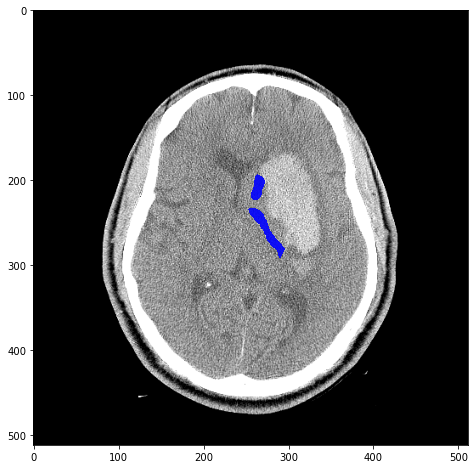

In [7]:
patient = "2151"
ct_ind = ct_ids.tolist().index(patient)
a_ind = PLIC_new_id_adrian.tolist().index(patient)
fig, (ax1) = plt.subplots(nrows =1, ncols = 1, figsize = (20,8))
window = 80
level = 40

vmin = (level/2) - window
vmax = (level/2) + window

imag = ct_scans[ct_ind][16]
imag[imag>vmax] = vmax
imag[imag<vmin] = vmin
PLIC_new_mask_adrian[a_ind] = PLIC_new_mask_adrian[a_ind].astype(float)
PLIC_new_mask_adrian[a_ind][16][PLIC_new_mask_adrian[a_ind][16] == 0] = np.nan

ax1.imshow(imag, cmap ='gray')
ax1.imshow(PLIC_new_mask_adrian[a_ind][16], alpha = 0.9, cmap = 'winter')


[[16, 17], [14, 15], [13, 14, 15], [], [], [11, 12], [], [], [15], [], [16, 17], [], [], [], [36, 37], [13, 14], [14, 15], [], [16, 17], [], [14, 15, 16], [], [14], [95, 96], [15, 16, 17], [], [18, 19, 20], [12, 13, 14], [], [], [58, 59, 60], [15, 16, 17, 18], [], [14, 15], [24, 25], [15, 16], [27, 28], [], [242, 243], [12, 14, 15], [16, 17], []] ['2049', '2424', '2047', '2477', '2484', '2479', '2025', '2217', '2413', '2227', '2151', '2134', '2159', '2121', '2110', '2144', '2142', '2453', '2465', '2431', '2463', '2455', '2096', '2054', '2213', '2445', '2086', '2027', '2488', '2073', '2410', '2136', '2389', '2141', '2058', '2033', '2461', '2492', '2066', '2494', '2469', '2451']
[14, 15, 16] [14, 15] [15] [15, 16, 17, 18]


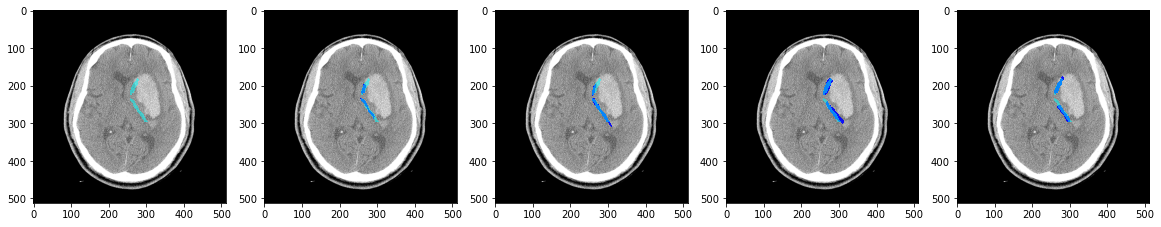

In [69]:
print (staple_slices, staple_ids)
patient = "2151"
staple_ind = staple_ids.index(patient)
ct_ind = ct_ids.tolist().index(patient)
a_ind = PLIC_new_id_adrian.tolist().index(patient)
p_ind = PLIC_new_id_paul.tolist().index(patient)
s_ind = PLIC_new_id_sacha.tolist().index(patient)
h_ind = PLIC_new_id_h.tolist().index(patient)
# printing figure for paper
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows =1, ncols = 5, figsize = (20,8))
window = 80
level = 40
print(slices_array_a[a_ind], slices_array_b[p_ind], slices_array_c[s_ind], slices_array_d[h_ind])
vmin = (level/2) - window
vmax = (level/2) + window

imag = ct_scans[ct_ind][16]
imag[imag>vmax] = vmax
imag[imag<vmin] = vmin

staple_array[staple_ind][0] = staple_array[staple_ind][0].astype(float)
staple_array[staple_ind][0][staple_array[staple_ind][0] == 0] = np.nan

PLIC_new_mask_adrian[a_ind] = PLIC_new_mask_adrian[a_ind].astype(float)
PLIC_new_mask_adrian[a_ind][16][PLIC_new_mask_adrian[a_ind][16] == 0] = np.nan

PLIC_new_mask_paul[p_ind] = PLIC_new_mask_paul[p_ind].astype(float)
PLIC_new_mask_paul[p_ind][16][PLIC_new_mask_paul[p_ind][16] == 0] = np.nan

PLIC_new_mask_sacha[s_ind] = PLIC_new_mask_sacha[s_ind].astype(float)
PLIC_new_mask_sacha[s_ind][16][PLIC_new_mask_sacha[s_ind][16] == 0] = np.nan

PLIC_new_mask_h[h_ind] = PLIC_new_mask_h[h_ind].astype(float)
PLIC_new_mask_h[h_ind][16][PLIC_new_mask_h[h_ind][16] == 0] = np.nan


ax1.imshow(imag, cmap ='gray')
ax1.imshow(staple_array[staple_ind][0], alpha = 0.5, cmap = 'cool')

ax2.imshow(imag, cmap ='gray')
ax2.imshow(PLIC_new_mask_adrian[a_ind][16], alpha = 0.9, cmap = 'winter')
ax2.imshow(staple_array[staple_ind][0], alpha = 0.5, cmap = 'cool')

ax3.imshow(imag, cmap ='gray')
ax3.imshow(PLIC_new_mask_paul[p_ind][16], alpha = 0.9, cmap = 'winter')
ax3.imshow(staple_array[staple_ind][0], alpha = 0.5, cmap = 'cool')

ax4.imshow(imag, cmap ='gray')
ax4.imshow(PLIC_new_mask_sacha[s_ind][16], alpha = 0.9, cmap = 'winter')
ax4.imshow(staple_array[staple_ind][0], alpha = 0.5, cmap = 'cool')

ax5.imshow(imag, cmap ='gray')
ax5.imshow(PLIC_new_mask_h[h_ind][16], alpha = 0.9, cmap = 'winter')
ax5.imshow(staple_array[staple_ind][0], alpha = 0.5, cmap = 'cool')

In [14]:
from utils import IdSkip2
HA_PLIC_new_mask_adrian,HA_PLIC_new_id_adrian, HA_PLIC_new_mask_h,HA_PLIC_new_id_h, = IdSkip2(PLIC_ids_adrian, PLIC_ids_h, PLIC_mask_adrian, PLIC_masks_h)

NameError: name 'PLIC_mask_adrian' is not defined

idskip:  ['2053', '2075', '2011', '2332', '2165', '2263', '2252', '2146', '2432']
2085
[26, 27, 28]
 j:  26 [26, 27, 28] [25, 26]
true
dice:  0.5274499743458184
 j:  27 [26, 27, 28] [25, 26]
false
 j:  28 [26, 27, 28] [25, 26]
false
2049
[16, 17]
 j:  16 [16, 17] [16, 17]
true
dice:  0.7027027027027027
 j:  17 [16, 17] [16, 17]
true
dice:  0.29632620104965685
2424
[13, 14, 15]
 j:  13 [13, 14, 15] [13, 14, 15]
true
dice:  0.32997762863534674
 j:  14 [13, 14, 15] [13, 14, 15]
true
dice:  0.6931106471816284
 j:  15 [13, 14, 15] [13, 14, 15]
true
dice:  0.5707720588235294
2272
[15, 16, 17]
 j:  15 [15, 16, 17] [15, 16, 17]
true
dice:  0.3900709219858156
 j:  16 [15, 16, 17] [15, 16, 17]
true
dice:  0.6298828125
 j:  17 [15, 16, 17] [15, 16, 17]
true
dice:  0.4026294165981923
2047
[13, 14, 15]
 j:  13 [13, 14, 15] [13, 14, 15]
true
dice:  0.23834196891191708
 j:  14 [13, 14, 15] [13, 14, 15]
true
dice:  0.5050391937290034
 j:  15 [13, 14, 15] [13, 14, 15]
true
dice:  0.614240170031881
2477

/Users/oliviamurray/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


dice:  0.41274438812454745
 j:  16 [14, 15, 16] [15, 16]
true
dice:  0.22783389450056116
2410
[18, 19]
 j:  58 [58, 59, 60] [59, 60]
false
 j:  59 [58, 59, 60] [59, 60]
true
dice:  0.4546762589928058
 j:  60 [58, 59, 60] [59, 60]
true
dice:  0.45844952593418853
2351
[12, 13, 14, 15]
 j:  16 [16, 17, 18, 19] [16, 17, 18]
true
dice:  0.4985771200910643
 j:  17 [16, 17, 18, 19] [16, 17, 18]
true
dice:  0.4894230769230769
 j:  18 [16, 17, 18, 19] [16, 17, 18]
true
dice:  0.6036866359447005
 j:  19 [16, 17, 18, 19] [16, 17, 18]
false
2394
[14, 15, 16]
 j:  14 [14, 15, 16] [14, 15, 16]
true
dice:  0.5821997668091722
 j:  15 [14, 15, 16] [14, 15, 16]
true
dice:  0.5330899132816066
 j:  16 [14, 15, 16] [14, 15, 16]
true
dice:  0.6212800652262536
2136
[58, 59, 60]
 j:  15 [15, 16] [14, 15]
true
dice:  0.4980047885075818
 j:  16 [15, 16] [14, 15]
false
2107
[16, 17, 18, 19]
 j:  20 [20, 21, 22] [19, 20, 21, 22]
true
dice:  0.5536799459824443
 j:  21 [20, 21, 22] [19, 20, 21, 22]
true
dice:  0.55

/var/folders/63/yxgrlw0j4y3fdc338v19k0pw0000gn/T/ipykernel_1440/3767345869.py:282: RuntimeWarning: invalid value encountered in double_scalars
  avg = sum/length


id len:  98
2025
2027
2033
2047
2049
2054
2058
2060
2066
2073
2085
2086
2096
2107
2110
2121
2134
2136
2141
2142
2144
2146
2151
2153
2159
2174
2175
2178
2198
2200
2209
2212
2213
2216
2217
2223
2227
2239
2253
2257
2266
2272
2285
2306
2313
2316
2318
2321
2338
2345
2350
2351
2357
2381
2389
2394
2397
2401
2403
2410
2413
2414
2424
2431
2432
2434
2445
2451
2453
2455
2461
2463
2465
2469
2477
2479
2484
2488
2492
2494
idskip:  ['2085', '2272', '2414', '2216', '2397', '2306', '2338', '2313', '2175', '2174', '2401', '2257', '2266', '2285', '2212', '2223', '2351', '2394', '2332', '2107', '2198', '2153', '2350', '2357', '2381', '2178', '2321', '2345', '2318', '2316', '2263', '2403', '2060', '2239', '2253', '2434', '2209', '2200']
id len:  98
2011
2025
2027
2033
2047
2049
2053
2054
2058
2066
2073
2075
2086
2096
2110
2121
2134
2136
2141
2142
2144
2151
2159
2165
2213
2217
2227
2252
2389
2410
2413
2424
2431
2445
2451
2453
2455
2461
2463
2465
2469
2477
2479
2484
2488
2492
2494
idskip:  ['2085', '2272', '

F_onewayResult(statistic=0.32066074251860077, pvalue=0.7259674126580036)

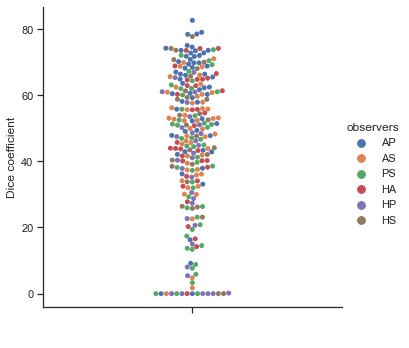

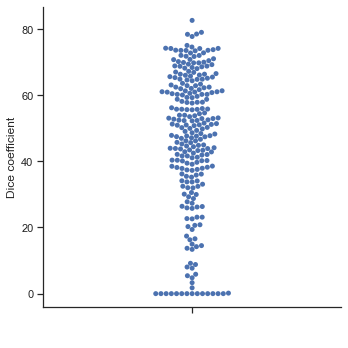

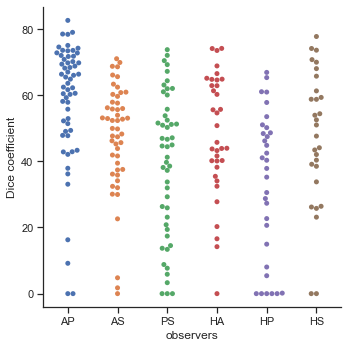

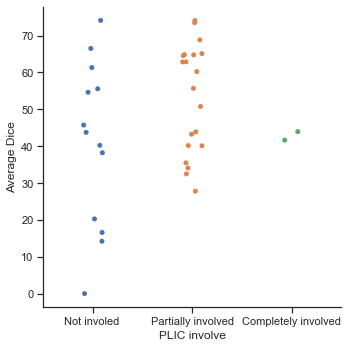

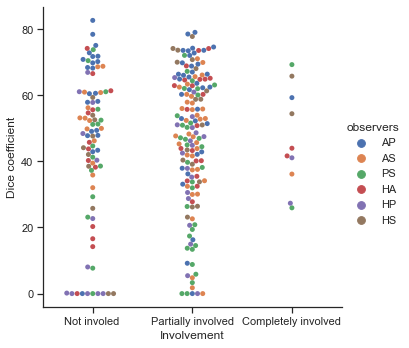

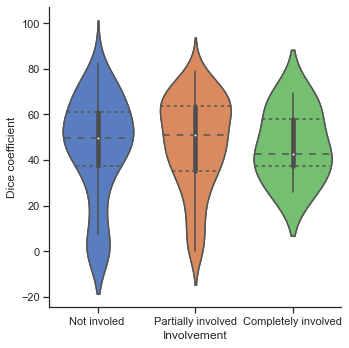

In [74]:
import seaborn as sns
sns.set_theme()
path_a = "/Users/olivia/Documents/PhD/MISTIE/mask_data/CRdata.xlsx"
patient = '2047'

#index1 = ct_ids.tolist().index(patient)
#index2 = staple_ids.index(patient)

#dice_arr = DiceCaster2(new_mask_adrian, new_id_adrian, cr_slices_adrian, new_mask_sacha, new_id_sacha, sacha_slices)
'''
dice_arr = DiceCaster2(PLIC_new_mask_adrian, PLIC_new_id_adrian, slices_array_a, ids_adrian, PLIC_new_mask_sacha, PLIC_new_id_sacha, slices_array_c, ids_sacha)
dice_arr2 = DiceCaster2(PLIC_new_mask_adrian, PLIC_new_id_adrian, slices_array_a,ids_adrian,PLIC_new_mask_paul, PLIC_new_id_paul, slices_array_b, ids_paul)
dice_arr3 = DiceCaster2(PLIC_new_mask_paul, PLIC_new_id_paul, slices_array_b,ids_paul,PLIC_new_mask_sacha, PLIC_new_id_sacha, slices_array_c, ids_sacha)
dice_arr4 = DiceCaster2(PLIC_new_mask_h, PLIC_new_id_h, slices_array_d,ids_h, PLIC_new_mask_adrian, PLIC_new_id_adrian, slices_array_a, ids_adrian)
dice_arr5 = DiceCaster2(PLIC_new_mask_h, PLIC_new_id_h, slices_array_d, ids_h, PLIC_new_mask_paul, PLIC_new_id_paul, slices_array_b, ids_paul)
dice_arr6 = DiceCaster2(PLIC_new_mask_h, PLIC_new_id_h, slices_array_d, ids_h, PLIC_new_mask_sacha, PLIC_new_id_sacha, slices_array_c, ids_sacha)
'''
dice_arr, id_as= DiceCaster2(PLIC_masks_adrian, PLIC_ids_adrian, slices_array_a, ids_adrian, PLIC_masks_sacha, PLIC_ids_sacha, slices_array_c, ids_sacha)
dice_arr2, id_ap = DiceCaster2(PLIC_masks_adrian, PLIC_ids_adrian, slices_array_a,ids_adrian,PLIC_masks_paul, PLIC_ids_paul, slices_array_b, ids_paul)
dice_arr3 , id_ps= DiceCaster2(PLIC_masks_paul, PLIC_ids_paul, slices_array_b,ids_paul,PLIC_masks_sacha, PLIC_ids_sacha, slices_array_c, ids_sacha)
dice_arr4, id_ha = DiceCaster2(PLIC_masks_h, PLIC_ids_h, slices_array_d,ids_h, PLIC_masks_adrian, PLIC_ids_adrian, slices_array_a, ids_adrian)
dice_arr5, id_hp = DiceCaster2(PLIC_masks_h, PLIC_ids_h, slices_array_d, ids_h, PLIC_masks_paul, PLIC_ids_paul, slices_array_b, ids_paul)
dice_arr6, id_hs = DiceCaster2(PLIC_masks_h, PLIC_ids_h, slices_array_d, ids_h, PLIC_masks_sacha, PLIC_ids_sacha, slices_array_c, ids_sacha)

AP_df = pd.DataFrame(dice_arr2, columns = ["Slice 1", "Slice 2", "Slice 3", "Slice 4", "Slice 5"],index = id_ap)
AS_df = pd.DataFrame(dice_arr, columns = ["Slice 1", "Slice 2", "Slice 3", "Slice 4"], index = id_as)
PS_df = pd.DataFrame(dice_arr3, columns = ["Slice 1", "Slice 2", "Slice 3", "Slice 4"], index = id_ps)
HA_df = pd.DataFrame(dice_arr4, columns = ["Slice 1", "Slice 2", "Slice 3", "Slice 4"], index = id_ha)
HP_df = pd.DataFrame(dice_arr5, columns = ["Slice1", "Slice 2", "Slice 3", "Slice 4", "Slice 5"], index = id_hp)
HS_df = pd.DataFrame(dice_arr6, columns = ["Slice1", "Slice 2", "Slice 3", "Slice 4"], index = id_hs)

AP_total_avg, AP_patient_avg = AverageDice(dice_arr2)
AS_total_avg, AS_patient_avg = AverageDice(dice_arr)
PS_total_avg, PS_patient_avg = AverageDice(dice_arr3)
HA_total_avg, HA_patient_avg = AverageDice(dice_arr4)
HP_total_avg, HP_patient_avg = AverageDice(dice_arr5)
HS_total_avg, HS_patient_avg = AverageDice(dice_arr6)
print("avg len: ",len(AP_patient_avg),len(AS_patient_avg),len(PS_patient_avg),len(HA_patient_avg),len(HP_patient_avg),len(HS_patient_avg) )
#Get involved info
a_info_path = "/Users/oliviamurray/Documents/PhD/MISTIE/PRIME_ICH_Data.xlsx"
ap_involve = GetInvolved(PLIC_ids_adrian, PLIC_ids_paul, PLIC_masks_adrian, PLIC_masks_paul)
as_involve = GetInvolved(PLIC_ids_adrian, PLIC_ids_sacha, PLIC_masks_adrian, PLIC_masks_sacha)
ps_involve = GetInvolved(PLIC_ids_paul, PLIC_ids_sacha, PLIC_masks_paul, PLIC_masks_sacha)
ha_involve = GetInvolved(PLIC_ids_h, PLIC_ids_adrian, PLIC_masks_h, PLIC_masks_adrian)
hp_involve = GetInvolved(PLIC_ids_h, PLIC_ids_paul, PLIC_masks_h, PLIC_masks_paul)
hs_involve = GetInvolved(PLIC_ids_h, PLIC_ids_sacha, PLIC_masks_h, PLIC_masks_sacha)


scale = np.array(range(0, len(PLIC_ids_adrian)))
AP_df["PLIC involve"] = ap_involve
AS_df["PLIC involve"] = as_involve
PS_df["PLIC involve"] = ps_involve
HA_df["PLIC involve"] = ha_involve
HP_df["PLIC involve"] = hp_involve
HS_df["PLIC involve"] = hs_involve
#HA_df["scale"]        = scale
AP_df["Average Dice"] = AP_patient_avg
AS_df["Average Dice"] = AS_patient_avg
PS_df["Average Dice"] = PS_patient_avg
HA_df["Average Dice"] = HA_patient_avg
HP_df["Average Dice"] = HP_patient_avg
HS_df["Average Dice"] = HS_patient_avg

#flattened dice array for category plotting
flat_arr = AP_patient_avg + AS_patient_avg + PS_patient_avg + HA_patient_avg + HP_patient_avg + HS_patient_avg
observer_ap = (['AP'] * len(AP_patient_avg)) 
observer_as = (['AS'] * len(AS_patient_avg)) 
observer_ps = (['PS'] * len(PS_patient_avg)) 
observer_ha = (['HA'] * len(HA_patient_avg)) 
observer_hp = (['HP'] * len(HP_patient_avg)) 
observer_hs = (['HS'] * len(HS_patient_avg))
observers = observer_ap + observer_as + observer_ps + observer_ha + observer_hp + observer_hs
flat_involve = ap_involve + as_involve + ps_involve + ha_involve + hp_involve + hs_involve
#indexr = str(PLIC_new_id_adrian) +str(PLIC_new_id_adrian) +str(PLIC_new_id_adrian) +str(PLIC_new_id_adrian) +str(PLIC_new_id_adrian) +str(PLIC_new_id_adrian)
print("lens: ",len(flat_arr), len(flat_involve), len(observers))
indexr = list(range(0,252))
flat_df = pd.DataFrame(data = {'Dice coefficient' :flat_arr})
flat_df["Involvement"] = flat_involve
flat_df["observers"] = observers
dice_label = ([' '] * len(flat_arr))
flat_df[" "] = dice_label
total_df = pd.DataFrame([AP_total_avg, AS_total_avg, PS_total_avg, HA_total_avg, HP_total_avg, HS_total_avg], index =[ "Adrian Paul average Dice", "Adrian Sacha average Dice", "Paul Sacha average Dice", "H Adrian avg Dice", "H Paul average Dice", "H Sacha average Dice"] )
with pd.ExcelWriter('/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/PLIC_pairwise_involve.xlsx') as writer:  
    AP_df.to_excel(writer, sheet_name='Adrian  Paul')
    AS_df.to_excel(writer, sheet_name='Adrian Sacha')
    PS_df.to_excel(writer, sheet_name='Paul Sacha')
    HA_df.to_excel(writer, sheet_name="H Adrian")
    HP_df.to_excel(writer, sheet_name="H Paul")
    HS_df.to_excel(writer, sheet_name="H Sacha")
    total_df.to_excel(writer, sheet_name = 'total')


import seaborn as sns
sns.set_theme(style="ticks")
print("none")
"""
g = sns.catplot(x="flat_involve", y="flat_arr", hue = "observers", data=flat_df)
g = sns.catplot(x="flat_involve", y="flat_arr", data=flat_df)
print("strip")
g = sns.catplot(x="flat_involve", y="flat_arr", hue = "observers", data=flat_df, kind = "strip")
g = sns.catplot(x="flat_involve", y="flat_arr", data=flat_df, kind = "strip")
print("swarm")
g = sns.catplot(x="flat_involve", y="flat_arr", hue = "observers", data=flat_df, kind = "swarm")
g = sns.catplot(x="flat_involve", y="flat_arr",  data=flat_df, kind = "swarm")
print("box")
g = sns.catplot(x="flat_involve", y="flat_arr", hue = "observers", data=flat_df, kind = "box")
g = sns.catplot(x="flat_involve", y="flat_arr", data=flat_df, kind = "box")
print("violin")
g = sns.catplot(x="flat_involve", y="flat_arr", hue = "observers", data=flat_df, kind = "violin")
g = sns.catplot(x="flat_involve", y="flat_arr", data=flat_df, kind = "violin")
print("boxen")
g = sns.catplot(x="flat_involve", y="flat_arr", hue = "observers", data=flat_df, kind = "boxen")
g = sns.catplot(x="flat_involve", y="flat_arr", data=flat_df, kind = "boxen")

print("point")
g = sns.catplot(x="flat_involve", y="flat_arr", hue = "observers", data=flat_df, kind = "point")
g = sns.catplot(x="flat_involve", y="flat_arr", data=flat_df, kind = "point")
print("bar")

g = sns.catplot(x="flat_involve", y="flat_arr", hue = "observers", data=flat_df, kind = "bar")
g = sns.catplot(x="flat_involve", y="flat_arr", data=flat_df, kind = "bar")
print("count")
"""
g = sns.catplot( y="Dice coefficient", x = " ", hue = "observers", data=flat_df, kind = "swarm")
g = sns.catplot( y="Dice coefficient",x = " ", data=flat_df, kind = "swarm")
g = sns.catplot( y="Dice coefficient",x = "observers", data=flat_df, kind = "swarm")

g = sns.catplot(x="PLIC involve", y="Average Dice", data=HA_df)

g = sns.catplot(x="Involvement", y='Dice coefficient', hue = "observers", data=flat_df, kind = "swarm")
g = sns.catplot(x="Involvement", y='Dice coefficient',  data=flat_df, kind = "violin")

ax = sns.violinplot(x="Involvement", y="Dice coefficient",
                    data=flat_df, palette="muted", inner = "quartile")
"""
print(np.unique(new_mask_adrian[index3][15]))
plt.imshow(ct_scans[index1][15], cmap = "gray")
strdt = (new_mask_adrian[index3][15])
print(np.unique(strdt))
strdt[strdt == 0] = 'NaN'
#new_mask_adrian[index3][15][new_mask_adrian[index3][15]==0] = np.nan
plt.imshow(new_mask_adrian[index3][15], alpha = 0.5)
"""
from scipy.stats import ttest_ind
from scipy.stats import ttest_ind, f_oneway

cat1 = flat_df[flat_df['Involvement']=='Not involed ']
cat2 = flat_df[flat_df['Involvement']=='Partially involved']
cat3 = flat_df[flat_df['Involvement']=='Completely involved']
cat1_nonan = cat1.dropna()
cat2_nonan = cat2.dropna()
cat3_nonan = cat3.dropna()
print(len(cat1), len(cat2))
#ttest_ind(cat2_nonan['Dice coefficient'], cat3_nonan['Dice coefficient'])
f_oneway(cat1_nonan['Dice coefficient'], cat2_nonan['Dice coefficient'], cat3_nonan['Dice coefficient'])

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
'''
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x, y)
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(x, y, 'tab:orange')
axs[0, 1].set_title('Axis [0, 1]')
axs[1, 0].plot(x, -y, 'tab:green')
axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(x, -y, 'tab:red')
axs[1, 1].set_title('Axis [1, 1]')
'''
'''
fig,axs = plt.subplots(1, 5)

for i in range(0,77):
    for j in range(0,4):
        axs[0, j].imshow(staple_array[i][j])
    for ax in axs.flat:
        ax.set(xlabel='x-label', ylabel='y-label')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
'''
for i in range(0,77):
    if len(staple_array[i]) != 0:
        ncols = len(staple_array[i])
        fig = plt.figure(figsize=(10., 10.))
        grid = ImageGrid(fig, 111,  # similar to subplot(111)
                        nrows_ncols=(1, ncols),  # creates 2x2 grid of axes
                        axes_pad=0.5,  # pad between axes in inch.
                        )

        for ax, im in zip(grid, staple_array[i]):
            # Iterating over the grid returns the Axes.
            ax.imshow(im)

        plt.show()

In [72]:
# make Fleiss table 
import pandas as pd
import numpy as np
def get_involved_array(initials, path):
    data_frame = pd.read_excel(path, sheet_name= initials, usecols = ['PRIME ID', 'PLIC involvement ', 'ALIC involvement ', 'CR involvement '])
    ids = data_frame['PRIME ID'].tolist()
    plic_involve = data_frame['PLIC involvement '].tolist()
    alic_involve = data_frame['ALIC involvement '].tolist()
    cr_involve = data_frame['CR involvement '].tolist()

    for i in range(0, len(ids)):
        ids[i] = str(ids[i])
        ids[i] = ids[i][:4]
    return ids, plic_involve, alic_involve, cr_involve
data_path = "/Users/oliviamurray/Documents/PhD/MISTIE/PRIME_ICH_Data.xlsx"

ids_adrian, a_plic_involve, a_alic_involve, a_cr_involve= get_involved_array("APJ", data_path )
ids_paul, p_plic_involve, p_alic_involve, p_cr_involve = get_involved_array("PR", data_path )
ids_sacha, s_plic_involve, s_alic_involve, s_cr_involve = get_involved_array("SC", data_path )
ids_h, h_plic_involve, h_alic_involve, h_cr_involve = get_involved_array("H", data_path )


total_id_array = []


for patient in ids_paul:
    
    patient_str = str(patient)
    patient_4 = patient_str[:4]

    if patient_4 not in total_id_array:
        total_id_array.append(patient_4)
for patient in ids_adrian:
    patient_str = str(patient)
    patient_4 = patient_str[:4]
    if patient_4 not in total_id_array:
        total_id_array.append(patient_4)
for patient in ids_h:
    patient_str = str(patient)
    patient_4 = patient_str[:4]
    if patient_4 not in total_id_array:
        total_id_array.append(patient_4)
for patient in ids_sacha:
    patient_str = str(patient)
    patient_4 = patient_str[:4]

    if patient_4 not in total_id_array:
        total_id_array.append(patient_4)

partial_id_array=[]
for patient in ids_adrian:
    if patient in ids_paul and patient in ids_sacha and patient in ids_h:
        partial_id_array.append(patient)




def make_fleiss_table(total_id_array, a_involve, a_id_array, p_involve, p_id_array, s_involve, s_id_array, h_involve, h_id_array):
    fleiss_table = []
    fleiss_table = np.zeros((len(total_id_array),3), dtype = int )
    for i in range(0, len(fleiss_table)):

            if total_id_array[i] in a_id_array:
                patient = total_id_array[i]
                index = a_id_array.index(patient)
                
                
                if a_involve[index] == 'Completely involved' or a_involve[index] == 'Completely involved ':
                    fleiss_table[i][0] += 1  

                if a_involve[index] == 'Partially involved' or a_involve[index] == 'Partially involved ':
                    fleiss_table[i][1] += 1
                if a_involve[index] == 'Not involed' or a_involve[index] == 'Not involed ':
                    fleiss_table[i][2] += 1
                
            if total_id_array[i] in p_id_array:
                patient = total_id_array[i]
                index = p_id_array.index(patient)
                
                if p_involve[index] == 'Completely involved' or p_involve[index] == 'Completely involved ':
                    fleiss_table[i][0] += 1
                if p_involve[index] == 'Partially involved' or p_involve[index] == 'Partially involved ':
                    fleiss_table[i][1] += 1
                    
                if p_involve[index] == 'Not involed' or p_involve[index] == 'Not involed ':
                    fleiss_table[i][2] += 1
                
            if total_id_array[i] in s_id_array:
                patient = total_id_array[i]
                index = s_id_array.index(patient)
                if s_involve[index] == 'Completely involved' or s_involve[index] == 'Completely involved ':
                    fleiss_table[i][0] += 1
                if s_involve[index] == 'Partially involved' or s_involve[index] == 'Partially involved ':
                    fleiss_table[i][1] += 1
                if s_involve[index] == 'Not involed' or s_involve[index] == 'Not involed ':
                    fleiss_table[i][2] += 1
                
            if total_id_array[i] in h_id_array:
                patient = total_id_array[i]
                index = h_id_array.index(patient)
                if h_involve[index] == 'Completely involved' or h_involve[index] == 'Completely involved ':
                    fleiss_table[i][0] += 1
                if h_involve[index] == 'Partially involved' or h_involve[index] == 'Partially involved ':
                    fleiss_table[i][1] += 1
                if h_involve[index] == 'Not involed' or h_involve[index] == 'Not involed ':
                    fleiss_table[i][2] += 1
            if sum(fleiss_table[i] != 4):
                np.delete(fleiss_table,i)


                
            
    return fleiss_table
plic_fleiss_table = make_fleiss_table(partial_id_array, a_plic_involve, ids_adrian, p_plic_involve, ids_paul, s_plic_involve, ids_sacha, h_plic_involve, ids_h)
print( "\nALIC: \n" )
alic_fleiss_table = make_fleiss_table(partial_id_array, a_alic_involve, ids_adrian, p_alic_involve, ids_paul, s_alic_involve, ids_sacha, h_alic_involve, ids_h)
print( "\nCR: \n" )
cr_fleiss_table = make_fleiss_table(partial_id_array, a_cr_involve, ids_adrian, p_cr_involve, ids_paul, s_cr_involve, ids_sacha, h_cr_involve, ids_h)


ALIC: 


CR: 



In [99]:
# removing rows that don't add up to 4
def remove_unranked(table):
    new_table = table
    delete_i = []
    print(len(new_table))
    for i in range (0, len(table)):
        if sum(table[i]) != 4:
            delete_i.append(i)
    print(delete_i)
          
    new_table = np.delete(new_table, delete_i,0)
    print(len(new_table)) 
    return new_table

plic_ranked_table = remove_unranked(plic_fleiss_table)
alic_ranked_table = remove_unranked(alic_fleiss_table)
cr_ranked_table = remove_unranked(cr_fleiss_table)

61
[]
61
61
[6, 11, 16, 17, 18, 20, 22, 23, 57]
52
61
[17, 18]
59


In [83]:
def custom_fleiss_kappa(table):   
    table = 1.0 * np.asarray(table)   #avoid integer division
    n_sub, n_cat =  table.shape
    n_total = table.sum()
    n_rater = table.sum(1)
    n_rat = n_rater.max()
    #assume fully ranked
    assert n_total == n_sub * n_rat
    
    #marginal frequency  of categories
    p_cat = table.sum(0) / n_total

    table2 = table * table
    p_rat = (table2.sum(1) - n_rat) / (n_rat * (n_rat - 1.))
    p_mean = p_rat.mean()

  
    p_mean_exp = (p_cat*p_cat).sum()


    kappa = (p_mean - p_mean_exp) / (1- p_mean_exp)
    return kappa


In [101]:
from statsmodels.stats.inter_rater import fleiss_kappa
plic_kappa = fleiss_kappa(plic_ranked_table, method='fleiss')
alic_kappa = custom_fleiss_kappa(alic_ranked_table)
cr_kappa = fleiss_kappa(cr_ranked_table, method='fleiss')

print("plic_kappa: ", plic_kappa)
print("alic_kappa: ", alic_kappa)
print("cr_kappa: ", cr_kappa)

208.0 208.0
plic_kappa:  0.44942990075680456
alic_kappa:  0.33696785533410795
cr_kappa:  0.4719741629214577


In [ ]:
slices_a = GetSlicesArray(new_mask_adrian)
slices_p = GetSlicesArray(new_mask_paul)
slices_s = GetSlicesArray(new_mask_sacha)

In [ ]:
#slices_s = GetSlicesArray(new_mask_adrian)
for id in ids_h:
    if id == '2011':
        place_holder = ids_h.tolist().index(id)
        print(h_slices[place_holder])
        
        plt.imshow(masks_h[place_holder][5])
        area = np.sum(masks_h[place_holder][5])
        print(area)

In [23]:
CT_matched_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/ct_matched_training.npz'
ct_matched_scan, ct_matched_ids = UnpackNpz(CT_matched_path)

2479


TypeError: 'numpy.int64' object is not iterable

In [24]:
from utils import Save2DData
#matching slice id, mask id to ct_matched id to create 2d training data
training_masks, training_cts, training_slices, training_ids = [],[],[],[]
for id in ct_matched_ids:

    if id in ids_sacha and id in PLIC_new_id_sacha:
        print(id)
        training_ids.append(id)
        mask_pl = PLIC_new_id_sacha.tolist().index(id)
        cts_pl = ct_matched_ids.tolist().index(id)
        slices_pl = ids_sacha.tolist().index(id)
        training_masks.append(PLIC_new_mask_sacha[mask_pl])
        training_cts.append(ct_matched_scan[cts_pl])
        training_slices.append(slices_array_c[slices_pl])

print(len(training_cts), len(training_ids), len(training_masks), len(training_slices))
save_p = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/sacha_matched_2d_training.npz'
from utils import Save2DCT
d = Save2DData(training_cts, training_ids, training_masks, training_ids, training_slices, training_ids, save_p )

2479
2217
2413
2151
2110
2144
2142
2465
2431
2463
2096
2213
2086
2027
2488
2141
2058
2033
2461
2494
20 20 20 20
2479
slice:  11
slice:  12
2217
slice:  23
slice:  24
slice:  25
slice:  26
slice:  27
2413
slice:  15
2151
slice:  16
slice:  17
2110
slice:  36
slice:  37
2144
slice:  13
slice:  14
2142
slice:  13
slice:  14
slice:  15
2465
slice:  15
slice:  16
slice:  17
slice:  18
2431
2463
slice:  14
slice:  15
slice:  16
2096
slice:  14
slice:  15
slice:  16
2213
slice:  16
slice:  17
slice:  18
2086
slice:  18
slice:  19
slice:  20
2027
slice:  12
slice:  13
slice:  14
2488
slice:  12
slice:  13
slice:  14
slice:  15
slice:  16
2141
slice:  14
slice:  15
2058
slice:  24
slice:  25
slice:  26
slice:  27
2033
slice:  13
slice:  14
slice:  15
2461
slice:  26
slice:  27
slice:  28
slice:  29
2494
slice:  14
slice:  15
slice:  16


In [41]:
patient = '2217'
#st_ind = staple_ids.index(patient)
a_ind = PLIC_new_id_adrian.tolist().index(patient)

print(np.unique(PLIC_new_mask_adrian[a_ind][15]))

[0]


In [44]:

#st_ind = staple_ids.index(patient)
a_ind = PLIC_new_id_adrian.tolist().index(patient)
p_ind = PLIC_new_id_paul.tolist().index(patient)
s_ind = PLIC_new_id_sacha.tolist().index(patient)
h_ind = PLIC_new_id_h.tolist().index(patient)
ct_ind = ct_ids.tolist().index(patient)

print(slices_array_a[a_ind], slices_array_b[p_ind], slices_array_c[s_ind], slices_array_d[h_ind])


PLIC_new_mask_adrian[a_ind] = PLIC_new_mask_adrian[a_ind].astype(float)/255
PLIC_new_mask_adrian[a_ind][11][PLIC_new_mask_adrian[a_ind][11]!=1]=np.nan
PLIC_new_mask_paul[p_ind] = PLIC_new_mask_paul[p_ind].astype(float)/255
PLIC_new_mask_paul[p_ind][11][PLIC_new_mask_paul[p_ind][11]!=1]=np.nan
PLIC_new_mask_sacha[s_ind] = PLIC_new_mask_sacha[s_ind].astype(float)/255
PLIC_new_mask_sacha[s_ind][11][PLIC_new_mask_sacha[s_ind][11]!=1]=np.nan
PLIC_new_mask_h[h_ind] = PLIC_new_mask_h[h_ind].astype(float)/255
PLIC_new_mask_h[h_ind][11][PLIC_new_mask_h[h_ind][11]!=1]=np.nan



[11, 12, 13, 14] [11, 12, 13] [11, 12] [22, 24, 26]


[11, 12, 13, 14] [11, 12, 13] [11, 12] [22, 24, 26]
[nan nan nan ... nan nan nan]


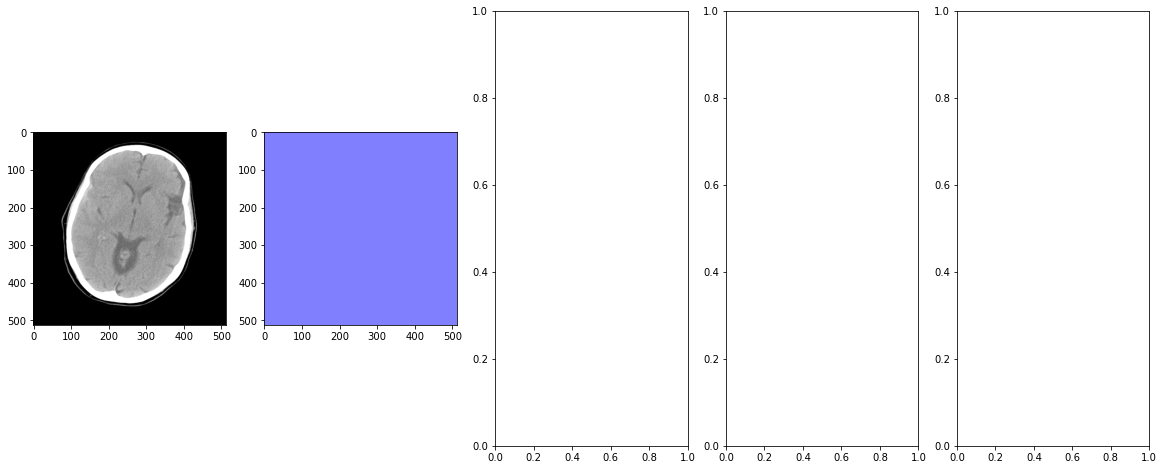

In [46]:
def ImageFlipperUD(image):
    image = np.flip(image, axis=0) 
    return image
patient = '2217'
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows =1, ncols = 5, figsize = (20,8))
window = 80
level = 40
print(slices_array_a[a_ind], slices_array_b[p_ind], slices_array_c[s_ind], slices_array_d[h_ind])
vmin = (level/2) - window
vmax = (level/2) + window

imag = ct_scans[ct_ind][15]
imag[imag>vmax] = vmax
imag[imag<vmin] = vmin
ax1.imshow(imag, cmap ='gray')
#ax2.imshow(imag, cmap ='gray')
ax2.imshow(PLIC_new_mask_adrian[a_ind][12], alpha = 0.5, cmap = 'winter')
print(np.unique(PLIC_new_mask_adrian[a_ind][15]))

2110
14
[[  1.   0.   0.]
 [  0.   1. 167.]]
2110
14
[[  1.   0.   0.]
 [  0.   1. 167.]]
2110
14
[[  1.   0.   0.]
 [  0.   1. 167.]]
2110
14
[[  1.   0.   0.]
 [  0.   1. 167.]]
2110
14
[[  1.   0.   0.]
 [  0.   1. 167.]]
2110
14
[[  1.   0.   0.]
 [  0.   1. 167.]]
2463
20
[[ 1.  0.  0.]
 [ 0.  1. 50.]]
2463
20
[[ 1.  0.  0.]
 [ 0.  1. 50.]]
2463
20
[[ 1.  0.  0.]
 [ 0.  1. 50.]]
2463
20
[[ 1.  0.  0.]
 [ 0.  1. 50.]]
2086
26
[[ 1.  0.  0.]
 [ 0.  1. 42.]]
2086
26
[[ 1.  0.  0.]
 [ 0.  1. 42.]]
2086
26
[[ 1.  0.  0.]
 [ 0.  1. 42.]]
2027
27
[[   1.    0.    0.]
 [   0.    1. -217.]]
2027
27
[[   1.    0.    0.]
 [   0.    1. -217.]]
2027
27
[[   1.    0.    0.]
 [   0.    1. -217.]]
2027
27
[[   1.    0.    0.]
 [   0.    1. -217.]]
2141
33
[[   1.    0.    0.]
 [   0.    1. -210.]]
2141
33
[[   1.    0.    0.]
 [   0.    1. -210.]]
2141
33
[[   1.    0.    0.]
 [   0.    1. -210.]]
2141
33
[[   1.    0.    0.]
 [   0.    1. -210.]]
2058
34
[[ 1.  0.  0.]
 [ 0.  1. 40.]]
2058
34
[[

/var/folders/63/yxgrlw0j4y3fdc338v19k0pw0000gn/T/ipykernel_51281/2245215568.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1) = plt.subplots(1, 1, figsize=(12,3))


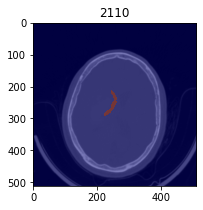

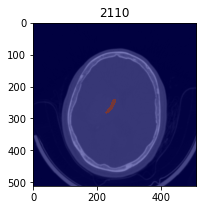

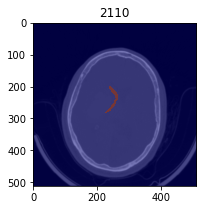

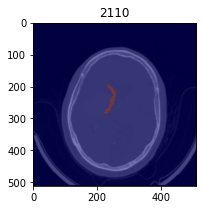

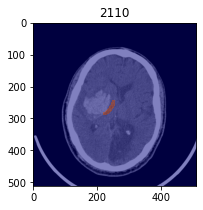

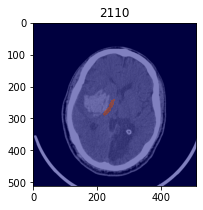

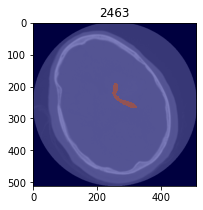

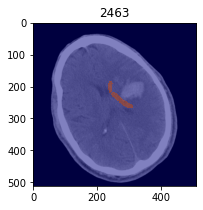

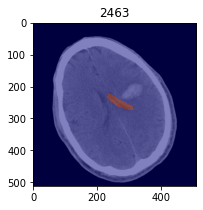

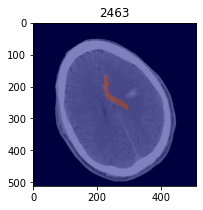

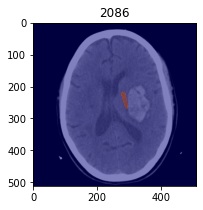

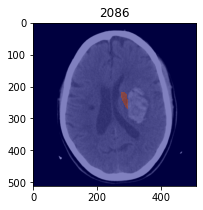

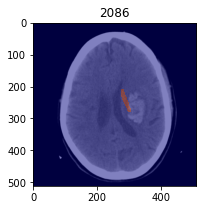

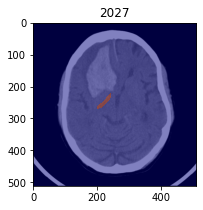

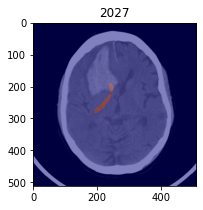

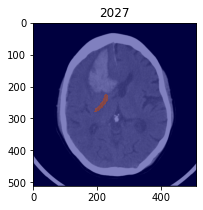

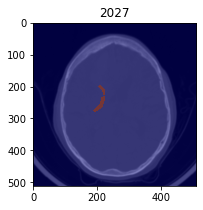

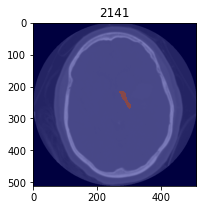

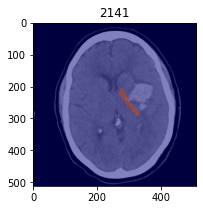

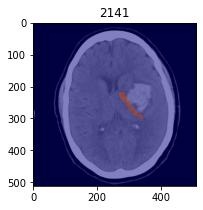

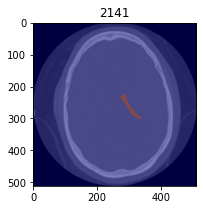

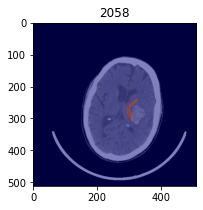

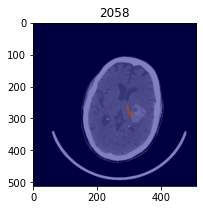

In [18]:
from PIL import ImageOps
import cv2
def ImageFlipperUD(image):
    image = np.flip(image, axis=0) 
    return image

"""
pathE = "/Users/olivia/Documents/PhD/MISTIE/mask_data/CRdata.xlsx"
patient = '2110'
placehold = ct_matched_ids.tolist().index(patient)
placehold2 = staple_ids.index(patient)
placehold3 = PLIC_new_id_adrian.tolist().index(patient)
placehold4 = PLIC_new_id_paul.tolist().index(patient)
placehold5 = PLIC_new_id_sacha.tolist().index(patient)
placehold6 = PLIC_new_id_h.tolist().index(patient)
imslices = staple_slices[placehold2]

#ct_scans[placehold] = ImageFlipper(ct_scans[placehold])
#new_mask_sacha[placehold3] = ImageFlipper(new_mask_sacha[placehold3])
#new_mask_adrian[placehold3] = ImageFlipperUD(new_mask_adrian[placehold3])
#slices = NewRemoveCoronaRadiataSlices(new_mask_sacha,new_id_sacha, pathE, sheetname ='sacha')
slices = GetSlices(new_mask_adrian[placehold3])
print("mask_len: ", len(new_mask_adrian[0]))
print(imslices)
window = 80
level = 40
#imslices= slices[placehold3]
vmin = (level/2) - window
vmax = (level/2) + window

index = 0
#print(len(ct_scans[placehold]))
ct_matched_scan[placehold][imslices[0]-1][ct_matched_scan[placehold][imslices[0]-1]>vmax] = vmax
ct_matched_scan[placehold][imslices[0]-1][ct_matched_scan[placehold][imslices[0]-1]<vmin] = vmin
image = ct_matched_scan[placehold][imslices[index]-1]


translation_matrix = np.float32([ [1,0,0], [0,1,40] ])
plt.imshow(new_mask_adrian[placehold3][imslices[0]])
img_translation = cv2.warpAffine(new_mask_adrian[placehold3][imslices[0]].astype(np.uint8), translation_matrix, (512, 512))
plt.imshow(img_translation)
#print("ct org: ", sitk.GetImageFromArray(ct_scans[placehold]).GetOrigin())
#plt.imshow(new_mask_adrian[placehold3][imslices[index]], alpha = 0.5)

fig, (ax1) = plt.subplots(1, 1, figsize=(12,3))
ax1.set_title("Rater 1")

seg1_err = np.zeros([512,512])  + img_translation #+ new_mask_sacha[placehold3][imslices[index]]
#seg2_err = np.zeros([512,512])   + s
#seg1_err_flip = ImageOps.flip(seg1_err)
ax1.imshow(np.clip(image, -350, 50), cmap='gray')
ax1.imshow(seg1_err,  cmap='jet', interpolation="none", alpha=0.5)
"""
patients = ['2110', '2463', '2086', '2027', '2141', '2058' ]
tranform_array = [np.float32([ [1,0,0], [0,1,167] ]), np.float32([ [1,0,0], [0,1,50] ]), np.float32([ [1,0,0], [0,1,42] ]), np.float32([ [1,0,0], [0,1,-217] ]),np.float32([ [1,0,0], [0,1,-210] ]), np.float32([ [1,0,0], [0,1,40] ])]
#used below for sacha 2110 matched 
#patients = ['2110', '2463', '2086', '2027', '2141', '2058' ]
#tranform_array = [np.float32([ [1,0,0], [0,1,235] ]), np.float32([ [1,0,0], [0,1,50] ]), np.float32([ [1,0,0], [0,1,42] ]), np.float32([ [1,0,0], [0,1,-217] ]),np.float32([ [1,0,0], [0,1,-210] ]), np.float32([ [1,0,0], [0,1,40] ])]


for j in range(0, len(patients)):

    place = ct_matched_ids.tolist().index(patients[j])
    place_slice= ids_paul.tolist().index(patients[j])
    place_a = PLIC_new_id_adrian.tolist().index(patients[j])
    place_p = PLIC_new_id_paul.tolist().index(patients[j])
    place_s = PLIC_new_id_sacha.tolist().index(patients[j])
    place_h = PLIC_new_id_h.tolist().index(patients[j])
    #place_staple = staple_ids.index(patients[j])
    slices = slices_array_b[place_slice]
    for i in range(0, len(slices)):
        print(patients[j])
        print(place_p)
        print(tranform_array[j])


        fig, (ax1) = plt.subplots(1, 1, figsize=(12,3))
        title = patients[j]
        ax1.set_title(title)

        imag = ct_matched_scan[place][slices[i]]
        window = 80
        level = 40
   
        vmin = (level/2) - window
        vmax = (level/2) + window
        #ct_matched_scan[place][slices[i]][ct_matched_scan[place][slices[i]]>vmax] = vmax
        #ct_matched_scan[place][slices[i]][ct_matched_scan[place][slices[i]]<vmin] = vmin
        seg = np.zeros([512,512])  + PLIC_new_mask_paul[place_p][slices[i]] #+ new_mask_sacha[placehold3][imslices[index]]
        #seg2_err = np.zeros([512,512])   + s
        #seg1_err_flip = ImageOps.flip(seg1_err)
        ax1.imshow(imag, cmap='gray')
        


       
        PLIC_new_mask_paul[place_p][slices[i]] = cv2.warpAffine(PLIC_new_mask_paul[place_p][slices[i]].astype(np.uint8), tranform_array[j], (512, 512))
        #PLIC_new_mask_adrian[place_a] = PLIC_new_mask_adrian[place_a].astype(float)
        #PLIC_new_mask_adrian[place_a][slices[i]][PLIC_new_mask_adrian[place_a][slices[i]] == 0] = np.nan

        seg2_ = np.zeros([512,512])  + PLIC_new_mask_paul[place_p][slices[i]]
    
        ax1.imshow(seg2_,  cmap='jet', interpolation="none", alpha=0.5)
        
        #new_mask_paul[place_p][slices[i]] = cv2.warpAffine(new_mask_paul[place_p][slices[i]].astype(np.uint8), tranform_array[j], (512, 512))
        #new_mask_h[place_h][slices[i]] = cv2.warpAffine(new_mask_h[place_h][slices[i]].astype(np.uint8), tranform_array[j], (512, 512))
        #new_mask_sacha[place_s][slices[i]] = cv2.warpAffine(new_mask_sacha[place_s][slices[i]].astype(np.uint8), tranform_array[j], (512, 512))
        #staple_array[place_staple][i] = cv2.warpAffine(staple_array[place_staple][i].astype(np.uint8), tranform_array[j], (512, 512))
        




In [ ]:
def Save2DData(cts, ct_ids, masks, mask_ids, slices_arr, slices_ids, path):
    ct_2d_arr , mask_2d_arr, id_2d_arr, slice_2d_arr = [], [] ,[], []
    for i in range(len(ct_ids)):
        patient = ct_ids[i]
        place_slice = slices_ids.tolist().index(patient)
        place_mask = mask_ids.tolist().index(patient)
        slices = slices_arr[place_slice]
        masks[place_mask] = masks[place_mask].astype(float)
        for slic in slices:
            window = 80
            level = 40
    
            vmin = (level/2) - window
            vmax = (level/2) + window
            cts[i][slic][cts[i][slic]>vmax] = vmax
            cts[i][slic][cts[i][slic]<vmin] = vmin
            ct_2d = cts[i][slic]

            masks[place_mask][slic][masks[place_mask][slic] != 0] = 1
            masks[place_mask][slic][masks[place_mask][slic] == 0] = np.nan
            mask_2d = masks[place_mask][slic]
            id_2d = ct_ids[i]
            ct_2d_arr.append(ct_2d)
            mask_2d_arr.append(mask_2d)
            id_2d_arr.append(id_2d)
            slice_2d_arr.append(slic)

    np.savez(path, cts = ct_2d_arr, masks = mask_2d_arr,  ids = id_2d_arr, slices = slice_2d_arr) 
def Unpack2DNpz(path):
    
    data = np.load(path, allow_pickle=True)
    cts = data['cts']
    masks = data['masks']
    ids = data['ids']
    slices = data['slices']
    return cts, masks, ids, slices
#data = Save2DData(ct_matched_scan,ct_matched_ids, PLIC_new_mask_adrian, PLIC_new_id_adrian, slices_array_a, ids_adrian, path =  '/Users/olivia/Documents/PhD/MISTIE/mask_data/adrian_matched_2d_training.npz')
cts, masks, ids, slices = Unpack2DNpz('/Users/olivia/Documents/PhD/MISTIE/mask_data/adrian_matched_2d_training.npz')
for i in range(len(cts)):

    fig, (ax1) = plt.subplots(1, 1, figsize=(12,3))
    title = str(ids[i]) + " " + str(slices[i])
    ax1.set_title(title)
    ax1.imshow(cts[i], cmap = 'gray')
    ax1.imshow(masks[i], cmap = 'jet', alpha = 0.5)
#data = Save2DData(ct_matched_scan,ct_matched_ids, PLIC_new_mask_adrian, PLIC_new_id_adrian, slices_array_a, ids_adrian, path =  '/Users/olivia/Documents/PhD/MISTIE/mask_data/adrian_matched_2d_training.npz')

In [ ]:
# get testing data not in matched CTs 

In [ ]:
fucked_up_array = []
for id in ct_ids:
    if id != '2121' and id != '2381':
        if id in new_id_adrian:

            place_holder = ct_ids.tolist().index(id)
            place_holder1 = new_id_adrian.tolist().index(id)
            print(id, " : ", len(ct_scans[place_holder]), len(new_mask_adrian[place_holder1]), len(new_mask_sacha[place_holder1]), len(new_mask_paul[place_holder1]), len(new_mask_h[place_holder1]))
            if len(ct_scans[place_holder]) != len(new_mask_adrian[place_holder1]):
                fucked_up_array.append(id)

print(fucked_up_array)

In [ ]:
from pathlib import Path
import nibabel as nib
from scipy import ndimage as ndi
def ReadMask(filedir, trans_affine):
    #seg = sitk.ReadImage(filedir, imageIO= "NiftiImageIO")  #="NiftiImageIO")
    seg = nib.load(filedir)
    print(seg.affine)
    seg_data = seg.get_fdata()
    print(seg_data.shape)
    seg_datat = ndi.affine_transform(seg_data, trans_affine)
    import matplotlib.pyplot as plt
    """
    def show_slices(slices):
        #Function to display row of image slices 
        fig, axes = plt.subplots(1, len(slices))
        for i, slice in enumerate(slices):
            axes[i].imshow(slice.T, cmap="gray", origin="lower")
        ax1.imshow(seg1_err,  cmap='jet', interpolation="none", alpha=0.5)
    slice_2 = seg_datat[:, :, 16, 0]
    show_slices([slice_2])
    """


    '''
    use this
    fig, (ax1) = plt.subplots(1, 1, figsize=(12,3))
    ax1.set_title("Rater 1")
    seg1_err = np.zeros([512,512])  + seg_datat[:, :, 16, 0]

    ax1.imshow(seg1_err,  cmap='jet', interpolation="none", alpha=0.5)
  
    '''

    """
    #print(seg.GetOrigin())
    #seg1_err = np.zeros([512,512]) + seg[20] 
    #seg_arr = sitk.GetArrayFromImage(seg)
    seg2_err = np.zeros([512,512]) + seg[15]
    seg_arr = seg_arr.astype(np.int64)
    seg3_err = np.zeros([512,512]) + seg[15]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3))

    # for display purposes, we will use "clip" to window the CT, as well as rotate the scan
   
    ax1.set_title("Rater 2")
 
    ax1.imshow(seg2_err,  cmap='jet', interpolation="none", alpha=0.5)

    # display segmentations from our three raters
    ax2.set_title("Rater 1")

    ax2.imshow(seg2_err,  cmap='jet', interpolation="none", alpha=0.5)
    ax3.set_title("Rater 2")

    ax3.imshow(seg3_err,  cmap='jet', interpolation="none", alpha=0.5)
    """
    return seg
patient = '2141'
id = ids_adrian.tolist().index(patient)
al = GetSlices(masks_adrian[id])
print(al)


ct_nib = nib.load("/Users/olivia/Documents/PhD/MISTIE/matched_scan/2141/Diagnostic CT/nifti.nii.gz")
ct_data = ct_nib.get_fdata()
print(ct_data.shape)
print("ct affn: ",ct_nib.affine)
"""
ct_vox_center = (np.array(ct_data.shape) - 1) / 2
from nibabel.affines import apply_affine
import numpy.linalg as npl
apply_affine(ct_nib.affine, ct_vox_center)
ct_vox2mask_vox = npl.inv(mask.affine).dot(ct_nib.affine)
affn = apply_affine(ct_vox2mask_vox, ct_vox_center)
print(affn)
"""
translation_affine = np.array([[1, 0, 0, 0],
                    [0, 1, 0, -199],
                    [0, 0, 1, -510.5],
                    [0, 0, 0, 1]])
identity = np.array([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])
mask = ReadMask("/Users/olivia/Documents/PhD/MISTIE/adrianexp/2141/scan.hdr", translation_affine)
mask_2 = ReadMask("/Users/olivia/Documents/PhD/MISTIE/adrianexp/2141/scan.hdr",identity )
mask_2_data = mask_2.get_fdata()



import cv2
import numpy as np


num_rows, num_cols = mask_2.shape[:2]

translation_matrix = np.float32([ [1,0,-119], [0,1,-106] ])
img_translation = cv2.warpAffine(mask_2_data[:, :, 16, 0], translation_matrix, (512, 512))
#cv2.imshow('Translation', img_translation)
plt.imshow(img_translation)
plt.imshow(mask_2_data[:, :, 16, 0], alpha = 0.5)


transform_ct = ndi.affine_transform(ct_data, translation_affine)
#adj_ct = apply_affine(translation_affine, ct)
#ct_data = transform_ct.get_fdata()
import matplotlib.pyplot as plt
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

slice_0 = transform_ct[26, :, :]
slice_1 = transform_ct[:, 30, :]
slice_2 = transform_ct[:, :, 16]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")  
#ct = ReadMask2("/Users/olivia/Documents/PhD/MISTIE/matched_scan/2027/Diagnostic CT/nifti.nii.gz")
def GetFiles(filedir):
    entries = Path(filedir)
    fname, id, pathlist = [],[],[]
    idTick = 0
 
    for entry in entries.iterdir():
     idTick += 1
     skip = np.array([2006, 2031, 2170])
     if entry.name[0:4] != "2006" and entry.name[0:4] != ".DS_" and entry.name[0:4] != "2031" and entry.name[0:4] != "2170" and entry.name[0:4] != "2035":
        fname.append(entry.name)
        id.append(idTick)
        pathlist.append(str(filedir) + "/" + str(entry.name))
    return np.array(fname), np.array(id), np.array(pathlist)
    


In [ ]:
from utils import ImageFlipper
patient = '2058'
placehold = ct_matched_ids.tolist().index(patient)
placehold2 = staple_ids.index(patient)
#ct_matched_scan[placehold] = ImageFlipper(ct_matched_scan[placehold])
slices = staple_slices[placehold2]
window = 80
level = 40

vmin = (level/2) - window
vmax = (level/2) + window
ct_matched_scan[placehold][slices[0]][ct_matched_scan[placehold][slices[0]]>vmax] = vmax
ct_matched_scan[placehold][slices[0]][ct_matched_scan[placehold][slices[0]]<vmin] = vmin
plt.imshow(ct_matched_scan[placehold][slices[0]], cmap = 'gray')

In [ ]:
def SaveData(inputs, ids):
    path = '/Users/olivia/Documents/PhD/MISTIE/mask_data/ct_matched_training.npz'
    ids = np.array(ids)
    #print("final shape: ", inputs.shape,  ids.shape)
    np.savez(path, masks = inputs,  ids = ids) 
    print("Saved data") 
data = SaveData(ct_matched_scan, ct_matched_ids)

In [ ]:

for id in ct_matched_ids:
    if id != '2121' and id != '2085':
        print(id)
        id0 = ct_matched_ids.tolist().index(id)
        id1 = staple_ids.index(id)
        id2 = new_id_adrian.tolist().index(id)
        id3 = new_id_paul.tolist().index(id)
        id4 = new_id_sacha.tolist().index(id)
        id5 = new_id_h.tolist().index(id)
        imslices = staple_slices[id1]
        for i in range(0, len(imslices)):
            staple_array[id1][i] = staple_array[id1][i].astype(float)
            print(staple_array[id1][i].dtype)
            staple_array[id1][i][staple_array[id1][i] == 0] = np.nan
            blrag = staple_array[id1][i]
            seg1_err = np.zeros([512,512]) + staple_array[id1][i] + new_mask_adrian[id2][imslices[i]]
            seg2_err = np.zeros([512,512]) + staple_array[id1][i] + new_mask_paul[id3][imslices[i]]
            seg3_err = np.zeros([512,512]) + staple_array[id1][i] + new_mask_sacha[id4][imslices[i]]
            seg4_err = np.zeros([512,512]) + staple_array[id1][i]+ new_mask_h[id5][imslices[i]]
           
            

            window = 80
            level = 40
        
            vmin = (level/2) - window
            vmax = (level/2) + window
            ct_matched_scan[id0][imslices[i]][ct_matched_scan[id0][imslices[i]]>vmax] = vmax
            ct_matched_scan[id0][imslices[i]][ct_matched_scan[id0][imslices[i]]<vmin] = vmin
            image = ct_matched_scan[id0][imslices[i]]
            cttt = sitk.GetImageFromArray(image)
            # plot
            im = sitk.GetImageFromArray(new_mask_h[id5][imslices[i]])

            
            print("dir: ", im.GetDirection(), cttt.GetDirection() )
            print("org: ", im.GetOrigin(), cttt.GetOrigin())
            fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(12,3))

            # for display purposes, we will use "clip" to window the CT, as well as rotate the scan
            title = str(id) + " : " + str(i)
            ax1.set_title(title)
            ax1.imshow(np.clip(image, -350, 450), cmap='gray')

            # display segmentations from our three raters
            ax2.set_title("Rater 1")
            ax2.imshow(np.clip(image, -350, 50), cmap='gray')
            ax2.imshow(seg1_err,  cmap='jet', interpolation="none", alpha=0.7)
            ax3.set_title("Rater 2")
            ax3.imshow(np.clip(image, -350, 50), cmap='gray')
            ax3.imshow(seg2_err,  cmap='jet', interpolation="none", alpha=0.7)
            ax4.set_title("Rater 3")
            #ax4.imshow(np.rot90(np.clip(image, -350, 50), k=1), cmap='gray')
            ax4.imshow(np.clip(image, -350, 50), cmap='gray')
            ax4.imshow(seg3_err,  cmap='jet', interpolation="none", alpha=0.7)
            ax5.set_title("Rater 4")
            #ax4.imshow(np.rot90(np.clip(image, -350, 50), k=1), cmap='gray')
            ax5.imshow(np.clip(image, -350, 50), cmap='gray')
            ax5.imshow(seg4_err,  cmap='jet', interpolation="none", alpha=0.7)
            #plt.savefig("STAPLE_Error.png")
            plt.show()


In [ ]:

fig=plt.figure(figsize=(12, 90))
ax = []
rows = 100
columns = 4
#figure with 5 columns

for j in range(0, len(masks_h)):
  for i in h_slices[j]: #cr_slices_adrian[j]:
    ax.append(fig.add_subplot(rows, columns, i+1))
    title = str(ids_h[j])
    plt.title(title)
    plt.imshow(masks_h[j][i])
    
    
  
    plt.show()
    
  


In [53]:
def UnpackNpz(path):
    data = np.load(path, allow_pickle=True)
    image = data['image']
    ids = data['ids']
    return image, ids
path = "/Users/oliviamurray/Documents/PhD/MISTIE/my segmentations /internal_capsule_masks.npz"
path_ct = "/Users/oliviamurray/Documents/PhD/MISTIE/my segmentations /ct_scans.npz"
ct,ids = UnpackNpz(path_ct)
mask, mids = UnpackNpz(path)
print(len(mask), len(mids), len(ct))
slicej = GetSlicesArray(mask)
print(slices)

61 61 61
[24, 25]


In [62]:
def GetSlices(seg_arr):
    values= []
    for i in range(0,len(seg_arr)):
        #val = np.sum(seg_arr[i,:,:])
        val = np.sum(seg_arr[i])
        print(val)
        if val > 0:
            values.append(i)
    return values

def GetSlicesArray(masks):
    slices_array =[]
    for image in masks:
        slices = GetSlices(image)
        slices_array.append((slices))
    return np.asarray(slices_array)
slicej = GetSlicesArray(mask)
print(mask[2].shape)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3072
2913
2556
2095
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2553
2678
2576
2686
2546
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3166
3607
2895
2919
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2666
2610
2599
3271
2282
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2283
2420
2332
2530
1950
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2194
2702
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2447
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2514
2389
2050
2203
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


/Users/oliviamurray/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


61 61 61
[]
[0 1]
2227 2006
s []
24


TypeError: object of type 'int' has no len()

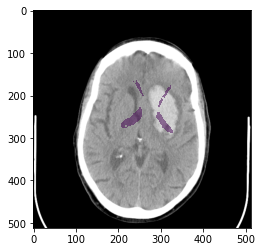

In [55]:
print(len(mask), len(mids), len(ct))
print(slicej)
print(np.unique(mask[1]))
window = 80
level = 40
print(ids[2], mids[2])
vmin = (level/2) - window
vmax = (level/2) + window
ct[2][28][ct[2][28]>vmax] = vmax
ct[2][28][ct[2][28]<vmin] = vmin
plt.imshow(ct[2][28], cmap = 'gray')
mask[2] = mask[2].astype(float)
mask[2][mask[2] == 0] = np.nan
plt.imshow(mask[2][28], alpha = 0.5)
s = GetSlices(mask[1])
print("s",s)
for i in range(0, len(mask)):
    print(slices[i])
    for sl in range(0, len(slices[i])):
        j = slices[sl]
        fig, ax = plt.subplots(1, 1, figsize=(12,3))

        # for display purposes, we will use "clip" to window the CT, as well as rotate the scan
        title = str(ids[i]) + " : " + str(j)
        ax.set_title(title)
        ax.imshow(np.clip(ct[i][j], -350, 450), cmap='gray')
        ax.imshow(mask[i][j], cmap = "jet", alpha = 0.5)
print(np.unique(mask))

In [10]:
staple_aplic_path = '/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/STAPLEcomparison.xlsx'
staple_aplic_dataframe = pd.read_excel(staple_aplic_path, sheet_name = [0] , usecols = ['Dice 1', 'Dice 2', 'Dice 3' ])
from IPython.display import display, HTML

# Assuming that dataframes df1 and df2 are already defined:
print ("Dataframe 1:")
display(staple_aplic_dataframe)

Dataframe 1:


{0:        Dice 1     Dice 2     Dice 3
 0   76.967233  59.954233        NaN
 1   80.601288  91.176471        NaN
 2   64.129401  69.586718        NaN
 3         NaN        NaN        NaN
 4         NaN        NaN        NaN
 5   83.666211  87.542662        NaN
 6         NaN        NaN        NaN
 7         NaN        NaN        NaN
 8   76.760367        NaN        NaN
 9         NaN        NaN        NaN
 10  74.779772  75.286822        NaN
 11        NaN        NaN        NaN
 12        NaN        NaN        NaN
 13        NaN        NaN        NaN
 14  97.204622  75.816375        NaN
 15  93.374741        NaN        NaN
 16  66.592241  69.537649        NaN
 17        NaN        NaN        NaN
 18  80.518079  69.509044        NaN
 19        NaN        NaN        NaN
 20  63.069467  79.301009  55.403557
 21        NaN        NaN        NaN
 22  89.727831        NaN        NaN
 23  42.391753  41.974378        NaN
 24  71.424020  83.021011        NaN
 25        NaN        NaN        Na

In [3]:
from utils import UnpackNpz
liv_masks, liv_ids = UnpackNpz('/Users/oliviamurray/Documents/PhD/MISTIE/my segmentations /internal_capsule_masks.npz')

In [4]:
import numpy as np
def UnpackNpzMask(path):
    
    data = np.load(path, allow_pickle=True)
    image = data['masks']
    ids = data['ids']
    return image, ids
staple_masks, staple_ids =  UnpackNpzMask('/Users/oliviamurray/Documents/PhD/MISTIE/mask_data/staple_masks.npz')


In [34]:
import fsl.transform.affine  as affinee
def centre_origin(img):
            # Rescale the voxel-to-world affine
        
        slices = len(img)
        arr = np.array(img)
        aff = np.eye(4)
        
        nib_file = nib.Nifti1Image(arr, aff)
        header = nib_file.header
        nifti_file = fsl.data.image.Nifti( header)
        shape = (1,512,512)
        xform = affinee.rescale(shape, shape, origin = 'centre')
        xform = affinee.concat(nifti_file.getAffine('voxel', 'world'), xform)
        header = nifti_file.header.copy()
 
        header.set_sform(     xform)
        header.set_qform(     xform)
        return fsl.data.image.Nifti(header)


2
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  2 512 512   1   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [1. 0. 0. 0.]
srow_y          : [0. 1.

AttributeError: 'Nifti' object has no attribute 'GetPixelIDValue'

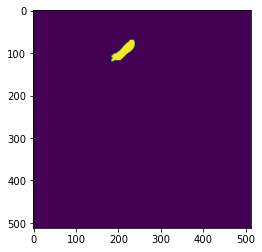

In [36]:
import matplotlib.pyplot as plt
import nibabel as nib
import SimpleITK as sitk
import cv2 
import fsl.data.image

print(len(staple_masks[1]))
plt.imshow(staple_masks[1][1])
len(staple_masks[1])
#for i in range(0, len(staple_masks)):
    #print(staple_ids[i],len(staple_masks[i]))
arr = np.array(staple_masks[1][0])
aff = np.eye(4)
nifti_file = nib.Nifti1Image(arr, aff)
header=nifti_file.header
print(header)
seg = nib.load('/Users/oliviamurray/Documents/PhD/MISTIE/my segmentations /Segmentations/2049_APLIC.nii.gz')  
header = seg.header


hdr = nib.load('/Users/oliviamurray/Documents/PhD/MISTIE/my segmentations /Segmentations/2049_APLIC.nii.gz')  

#pixdim_ = fsl.data.image.Nifti.pixdim(nifti_file)

#shape_ = fsl.data.image.Nifti.shape(nifti_file)
scaled_img = centre_origin(staple_masks[1][0])
#adjust = fsl.data.image.Nifti.adjust(nifti_file, shape=(1,512,512), pixdim = None,origin = 'centre')
scale = sitk.GetArrayFromImage(scaled_img)
plt.imshow(scale)

In [46]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import SimpleITK as sitk
import cv2 
import fsl.data.image
from utils import GetSlices
arr = np.array(staple_masks[1][0])
#plt.imshow(arr)

data= nifti_file.get_data()
seg = nib.load('/Users/oliviamurray/Documents/PhD/MISTIE/my segmentations /Segmentations/2049_APLIC.nii.gz')  
ct = nib.load('/Users/oliviamurray/Documents/PhD/MISTIE/my segmentations /Scans/2049.nii.gz')
adrian = sitk.ReadImage('/Users/oliviamurray/Documents/PhD/MISTIE/adrianexp/2049/scan.img', imageIO= "NiftiImageIO")
#adrian = nib.load('/Users/oliviamurray/Documents/PhD/MISTIE/adrianexp/2049/scan.img')
print("adrian seg",adrian.header)
aff = np.eye(4)
nifti_file = nib.Nifti1Image(arr, ct.affine)
header = ct.header
print("My ct",header)
adrian_data = adrian.get_data()

b = np.array(adrian.dataobj)
slices = GetSlices(b[:,:,:,0])
print(slices)
adrian_fsl = fsl.data.image.Nifti(adrian)

#plt.imshow(b[:,:,13,0])
comb_img = nib.Nifti1Image(adrian_data, ct.affine, ct.header)
print(comb_img.header)
a = np.array(adrian.dataobj)
c = np.array(ct.dataobj)
print(a.shape)
plt.imshow(c[:,:,16])
plt.imshow(a[:,:,16,0], alpha = 0.5)
adjust = fsl.data.image.Nifti.adjust(adrian_fsl, shape=(512, 512, 49), pixdim = None,origin = 'centre')

/var/folders/63/yxgrlw0j4y3fdc338v19k0pw0000gn/T/ipykernel_1440/731476206.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  data= nifti_file.get_data()
NiftiImageIO (0x7f81a1df4e70): /Users/oliviamurray/Documents/PhD/MISTIE/adrianexp/2049/scan.img is Analyze file and it's deprecated 

NiftiImageIO (0x7f81a1df4e70): /Users/oliviamurray/Documents/PhD/MISTIE/adrianexp/2049/scan.img is Analyze file and it's deprecated 



AttributeError: 'Image' object has no attribute 'header'

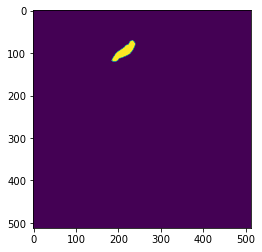

In [28]:
plt.imshow(a)